In [2]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import corner
import seaborn as sns
from numpy.polynomial import chebyshev
import random

#### run this cell to get the data needed.

In [12]:
ALLstardata = Table.read('./specdata/allstar.fits')
allstardata = pd.read_csv('./specdata/allstar')
# allspectra = pd.read_csv('./specdata/allspectra')
allnormalspectra = pd.read_csv('./specdata/allnormalspectra')
allnormalflux = np.load('./specdata/allnormalflux.npz')['arr_0']
allnormalerror = np.load('./specdata/allnormalerror.npz')['arr_0']
paras = np.load('./specdata/modelparas.npz')['arr_0']

In [4]:
train_percentage, valid_percentage = (0.50, 0.50)

from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(44)

# make an array with the indices of all the rows in the dataset
ind_arr = np.arange(len(allstardata))
rnd.shuffle(ind_arr)

train_ind, test_ind = train_test_split(ind_arr, train_size=train_percentage, random_state=rnd)
train_ind = np.sort(train_ind);test_ind = np.sort(test_ind)
train_obj = allstardata.iloc[train_ind]['APOGEE_ID']
crossval_obj = allstardata.iloc[test_ind]['APOGEE_ID']

#### Run this cell to use the self-define function!!

In [13]:
def get_wave(allwave=False,threechip=True,cutgaps=False):
    '''Function to get wavelength of APstars. This is based on the fact that the wavelength in all APstars files are the same.'''
    obj = '2M21235803+1231146'
    file = fits.open('./specdata/fitsdata/apo25m/M15/apStar-r12-'+obj+'.fits')
    data = file[1].data
    info = file[0].header
    file.close()

    wavescale = 10**(np.arange(info['CRVAL1'],info['CRVAL1']+info['NWAVE']*info['CDELT1'],info['CDELT1']))
    
    chip1 = wavescale[np.where((wavescale<15810)&(wavescale>15140))];
    chip2 = wavescale[np.where((wavescale>15850)&(wavescale<16440))];
    chip3 = wavescale[np.where((wavescale>16470)&(wavescale<16960))];
    
    if allwave==True:
        return wavescale
    elif cutgaps==True:
        return np.hstack((chip1,chip2,chip3))
    else:
        return [chip1,chip2,chip3]
    
def get_flux_err(filepath=None,obj=None,allspec=False,threechip=True,cutgaps=False):
    '''Get the spectrum and its error (processed by bitmask already) from the given file dictionary or object id.'''
    if obj!= None:
        field = ALLstardata['FIELD'][np.where(allstardata['APOGEE_ID']==obj)][0]
        file = fits.open('./specdata/fitsdata/apo25m/'+field+'/apStar-r12-'+obj+'.fits')
    if filepath!=None:
        file = fits.open(filepath)
    
    data = file[1].data
  
    if len(data.shape) == 1:
        specdata = file[1].data
        info = file[0].header
        error = file[2].data
        bitmask = file[3].data
        file.close()
    else:
        specdata = file[1].data[0]
        info = file[0].header
        error = file[2].data[0]
        bitmask = file[3].data[0]
        file.close()
    
    bmsum = 0
    for bit in [0,1,2,3,4,5,6,7,12]:
        bm = 2**bit
        bmsum += bm
    badpix = (bitmask & bmsum)!=0
    
    error[np.where(badpix==True)] = 1e10
    wavescale = 10**(np.arange(info['CRVAL1'],info['CRVAL1']+info['NWAVE']*info['CDELT1'],info['CDELT1']))
    
    flux1 = specdata[np.where((wavescale<15810)&(wavescale>15140))];err1 = error[np.where((wavescale<15810)&(wavescale>15140))]
    flux2 = specdata[np.where((wavescale>15850)&(wavescale<16440))];err2 = error[np.where((wavescale>15850)&(wavescale<16440))]
    flux3 = specdata[np.where((wavescale>16470)&(wavescale<16960))];err3 = error[np.where((wavescale>16470)&(wavescale<16960))]
    
    if allspec==True:
        return specdata,error
    if cutgaps==True:
        return np.hstack((flux1,flux2,flux3)),np.hstack((err1,err2,err3))
    else:
        return [flux1,flux2,flux3],[err1,err2,err3]

In [6]:
def get_continumm_wave():
    '''Get the wavelength in APOGEE file that closet to the continumm pixels.'''
    continuum = np.load('specdata/continuum_pixels_apogee.npz')
    conwave = continuum['wavelength'][np.where(continuum['is_continuum']==1)]

    # The following parameters are determined according to APOGEE document & plot of the wavelength
    chip1 = conwave[np.where((conwave>15140)&(conwave<15810))]
    chip2 = conwave[np.where((conwave>15850)&(conwave<16440))]
    chip3 = conwave[np.where((conwave>16470)&(conwave<16960))]
    return [chip1,chip2,chip3]

def get_continumm_chip(data,err,chip):
    '''Get the spectrum at continumm pixels from the given spectrum data(fitsfile[1].data).'''
    chip1,chip2,chip3 = get_continumm_wave()
    wavescale = get_wave()
    
    ind1 = [];ind2 = [];ind3 = []

    if chip ==1:
        for wave in chip1:
            index = np.where(abs(wavescale[0]-wave)==np.min(abs(wavescale[0]-wave)))[0][0]
            ind1.append(index)
        ind1 = np.unique(ind1)
        return data[ind1],err[ind1]
    if chip ==2:
        for wave in chip2:
            index = np.where(abs(wavescale[1]-wave)==np.min(abs(wavescale[1]-wave)))[0][0]
            ind2.append(index)
        ind2 = np.unique(ind2)
        return data[ind2],err[ind2]
    if chip ==3:
        for wave in chip3:
            index = np.where(abs(wavescale[2]-wave)==np.min(abs(wavescale[2]-wave)))[0][0]
            ind3.append(index)
        ind3 = np.unique(ind3)
        return data[ind3],err[ind3]

# Function to get chebyshev fit 2-D polynomial coeffcients
def get_continumm_fit_coeff(wave,specdata,err):
    '''
    Wave and Specdata should both be at continumm pixels, and therefore with same size.
    
    Return:
    ————————————————————————————
    Coeff from low to high order.
    '''
    newwave = wave[np.where((specdata!=0)&(err<1e9))]
    newspecdata = specdata[np.where((specdata!=0)&(err<1e9))]
    newerr = err[np.where((specdata!=0)&(err<1e9))]
#     newwave = wave[np.where((err<1e9))]
#     newspecdata = specdata[np.where((err<1e9))]
#     newerr = err[np.where((err<1e9))]
    an = chebyshev.chebfit(newwave,newspecdata,deg=2,w=1/newerr**2)
    cn = chebyshev.cheb2poly(an)
    return cn

def get_continumm_fit_flux(wave,cn):
    '''
    Wave should be the ones needed to be fit.
    Return:
    ————————————————————————————
    The fit flux from continumm spectrum.
    Could be use to do posuedo-normalization.
    '''
    return cn[2]*wave**2 + cn[1]*wave+cn[0]

def get_normalized_spectrum(wave,flux,err,chip):
    '''
    Given one of the chips wave&flux, return the normalized flux.
    Should clarify which chip data is given.
    Return:
    ————————————————————————————
    The pusuedo-normalized flux & error.
    '''
    w1,w2,w3 = get_continumm_wave()
    
    if chip==1:
        flux1,err1 = get_continumm_chip(flux,err,chip)
        cn = get_continumm_fit_coeff(w1,flux1,err1)
        f = get_continumm_fit_flux(wave,cn)
    elif chip==2:
        flux2,err2 = get_continumm_chip(flux,err,chip)
        cn = get_continumm_fit_coeff(w2,flux2,err2)
        f = get_continumm_fit_flux(wave,cn)
    elif chip==3:
        flux3,err3 = get_continumm_chip(flux,err,chip)
        cn = get_continumm_fit_coeff(w3,flux3,err3)
        f = get_continumm_fit_flux(wave,cn)
    else:
        print ('wrong chip!!!!')
        
    return flux/f,err/f

In [7]:
def get_normalized_spectra_fromdf(obj,alldata=True):
    
    data = allnormalspectra['flux_'+obj]
    err = allnormalspectra['error_'+obj]
    
    data1 = data[:3134];err1 = err[:3134]
    data2 = data[3134:5780];err2 = err[3134:5780]
    data3 = data[-2122:];err3 = err[-2122:]
    
    if alldata==True:
        return data,err
    else:
        return [data1,data2,data3],[err1,err2,err3]
    
def get_normalized_spectra_at_wave(objind,waveind):
    '''
    objs:
        should be a list of obj indices.
    
    wave:
        should be a single index.
        
    Return:
    ——————————————————————————
    return array(data) and arrat(errs)
    '''
    data = allnormalflux[objind,waveind]
    err = allnormalerror[objind,waveind]
    return data,err

In [8]:
mean_tf = np.mean(allstardata['TEFF'])
mean_logg = np.mean(allstardata['LOGG'])
mean_feh = np.mean(allstardata['M_H'])
mean_mgfe = np.mean(allstardata['MG_FE'])
mean_sife = np.mean(allstardata['SI_FE'])

In [9]:
def make_labels_matrix(objs):
    '''Make the len(objs)*21 matrix by the given objs.
    objs:
            list of objs, e.g. [obj1,obj2,obj3, ...]
    
    Return:
    ————————————————————————
    All 21 "labels" of every obj in row.
    '''
    tfs,loggs,FeHs,MgFes,SiFes = allstardata.loc[(allstardata['APOGEE_ID'].isin(objs)),\
                                                 ['TEFF','LOGG','M_H','MG_FE','SI_FE']].values.T
    
#     tfs/=mean_tf;loggs/mean_logg;FeHs/=mean_feh;MgFes/=mean_mgfe;SiFes/=mean_sife;
    tfs/=1e3
    

    tf2 = tfs**2;logg2 = loggs**2;FeH2 = FeHs**2;MgFe2 = MgFes**2;SiFe2 = SiFes**2

    tf_log = tfs*loggs ; tf_Fe = tfs*FeHs ; tf_Mg = tfs*MgFes ; tf_Si = tfs*SiFes
    log_Fe = loggs*FeHs ; log_Mg = loggs*MgFes ; log_Si = loggs*SiFes
    Fe_Mg = FeHs*MgFes ; Fe_Si = FeHs*SiFes ; Mg_Si = MgFes*SiFes

    return np.array([np.ones(len(objs)),tfs,loggs,FeHs,MgFes,SiFes,tf2,tf_log,tf_Fe,tf_Mg,tf_Si,\
                         logg2,log_Fe,log_Mg,log_Si,FeH2,Fe_Mg,Fe_Si,MgFe2,Mg_Si,SiFe2]).T

    
def make_labels_array(teff,logg,feh,mgfe,sife):
    '''Make the (21,) array by the given five labels.'''
    
#     tfs = teff/mean_tf; loggs = logg/mean_logg; FeHs = feh/mean_feh; MgFes = mgfe/mean_mgfe; SiFes = sife/mean_sife
    tfs = teff/1e3; loggs = logg; FeHs = feh; MgFes = mgfe; SiFes = sife


    tf2 = tfs**2;logg2 = loggs**2;FeH2 = FeHs**2;MgFe2 = MgFes**2;SiFe2 = SiFes**2

    tf_log = tfs*loggs ; tf_Fe = tfs*FeHs ; tf_Mg = tfs*MgFes ; tf_Si = tfs*SiFes
    log_Fe = loggs*FeHs ; log_Mg = loggs*MgFes ; log_Si = loggs*SiFes
    Fe_Mg = FeHs*MgFes ; Fe_Si = FeHs*SiFes ; Mg_Si = MgFes*SiFes
    return np.array([1,tfs,loggs,FeHs,MgFes,SiFes,tf2,tf_log,tf_Fe,tf_Mg,tf_Si,\
                     logg2,log_Fe,log_Mg,log_Si,FeH2,Fe_Mg,Fe_Si,MgFe2,Mg_Si,SiFe2])


# 1

In [2]:
with open('fields_file.txt','w') as f:
    f.write('M15/ \nN6791/ \nK2_C4_168-21/ \n060+00/')

In [3]:
! wget -nv -r -nH --cut-dirs=7 \
-i ./specdata/fields_file.txt \
-P ./specdata/ \
-B https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/

2021-03-15 18:57:24 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/ [418293] -> "./specdata/apo25m/M15/index.html" [1]
2021-03-15 18:57:25 URL:https://data.sdss.org/robots.txt [27/27] -> "./specdata/robots.txt" [1]
2021-03-15 18:57:25 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/ [84781] -> "./specdata/apo25m/N6791/index.html" [1]
2021-03-15 18:57:25 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/ [139125] -> "./specdata/apo25m/K2_C4_168-21/index.html" [1]
2021-03-15 18:57:25 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/ [313485] -> "./specdata/apo25m/060+00/index.html" [1]
FINISHED --2021-03-15 18:57:25--
Total wall clock time: 1.9s
Downloaded: 5 files, 933K in 0.7s (1.36 MB/s)


In [3]:
files = []

for field in ['M15','N6791','K2_C4_168-21','060+00']:
    file = open('./specdata/apo25m/'+field+'/index.html','r')
    handle = file.read()
    file.close()
    soup = BeautifulSoup(handle)
    
    for fitsfile in soup.find_all('a',string = re.compile('apStar-r12')):
        file = field+'/'+str(fitsfile)[45:79]+'\n'
        files.append(file)

In [81]:
with open('./specdata/fitsfile.txt','w') as f:
    f.writelines(files)

In [82]:
! wget -nv -r -nH --cut-dirs=7 \
-i ./specdata/fitsfile.txt \
-P ./specdata/fitsdata \
-B https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/

2021-03-15 20:39:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21233217+1211528.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21233217+1211528.fits" [1]
2021-03-15 20:39:31 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21233366+1147521.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21233366+1147521.fits" [1]
2021-03-15 20:39:34 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21234293+1241148.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21234293+1241148.fits" [1]
2021-03-15 20:39:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21234361+1138228.fits [4158720/4158720] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21234361+1138228.fits" [1]
2021-03-15 20:39:37 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:39:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21242622+1302227.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21242622+1302227.fits" [1]
2021-03-15 20:39:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21242815+1233389.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21242815+1233389.fits" [1]
2021-03-15 20:39:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21242840+1208285.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21242840+1208285.fits" [1]
2021-03-15 20:39:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21242921+1159325.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21242921+1159325.fits" [1]
2021-03-15 20:39:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:39:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21244928+1226029.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21244928+1226029.fits" [1]
2021-03-15 20:39:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21244949+1208283.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21244949+1208283.fits" [1]
2021-03-15 20:39:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21244951+1235118.fits [10526400/10526400] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21244951+1235118.fits" [1]
2021-03-15 20:39:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21245022+1245246.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21245022+1245246.fits" [1]
2021-03-15 20:39:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/a

2021-03-15 20:40:06 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21251203+1136374.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21251203+1136374.fits" [1]
2021-03-15 20:40:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21251239+1146016.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21251239+1146016.fits" [1]
2021-03-15 20:40:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21251277+1114033.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21251277+1114033.fits" [1]
2021-03-15 20:40:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21251326+1246221.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21251326+1246221.fits" [1]
2021-03-15 20:40:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:40:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21254492+1320271.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21254492+1320271.fits" [1]
2021-03-15 20:40:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21254525+1129219.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21254525+1129219.fits" [1]
2021-03-15 20:40:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21254635+1243538.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21254635+1243538.fits" [1]
2021-03-15 20:40:23 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21254714+1159515.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21254714+1159515.fits" [1]
2021-03-15 20:40:23 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:40:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21260475+1236216.fits [3470400/3470400] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21260475+1236216.fits" [1]
2021-03-15 20:40:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21260489+1105141.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21260489+1105141.fits" [1]
2021-03-15 20:40:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21260615+1314175.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21260615+1314175.fits" [1]
2021-03-15 20:40:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21260775+1112358.fits [4386240/4386240] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21260775+1112358.fits" [1]
2021-03-15 20:40:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:40:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21262850+1138426.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21262850+1138426.fits" [1]
2021-03-15 20:40:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21262924+1217362.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21262924+1217362.fits" [1]
2021-03-15 20:40:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21262950+1144460.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21262950+1144460.fits" [1]
2021-03-15 20:40:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21262965+1301067.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21262965+1301067.fits" [1]
2021-03-15 20:40:47 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:40:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21264859+1236226.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21264859+1236226.fits" [1]
2021-03-15 20:40:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21264886+1142399.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21264886+1142399.fits" [1]
2021-03-15 20:40:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21264886+1157489.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21264886+1157489.fits" [1]
2021-03-15 20:40:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21265007+1148166.fits [4386240/4386240] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21265007+1148166.fits" [1]
2021-03-15 20:40:58 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:41:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21271652+1056426.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21271652+1056426.fits" [1]
2021-03-15 20:41:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21271672+1324567.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21271672+1324567.fits" [1]
2021-03-15 20:41:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21271770+1218018.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21271770+1218018.fits" [1]
2021-03-15 20:41:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21271836+1058236.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21271836+1058236.fits" [1]
2021-03-15 20:41:09 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:41:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21273380+1116376.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21273380+1116376.fits" [1]
2021-03-15 20:41:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21273456+1141084.fits [4386240/4386240] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21273456+1141084.fits" [1]
2021-03-15 20:41:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21273481+1249407.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21273481+1249407.fits" [1]
2021-03-15 20:41:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21273493+1242426.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21273493+1242426.fits" [1]
2021-03-15 20:41:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:41:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21275109+1147252.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21275109+1147252.fits" [1]
2021-03-15 20:41:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21275154+1153037.fits [9858240/9858240] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21275154+1153037.fits" [1]
2021-03-15 20:41:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21275176+1219275.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21275176+1219275.fits" [1]
2021-03-15 20:41:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21275193+1214555.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21275193+1214555.fits" [1]
2021-03-15 20:41:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:41:36 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21281311+1249129.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21281311+1249129.fits" [1]
2021-03-15 20:41:37 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21281337+1152514.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21281337+1152514.fits" [1]
2021-03-15 20:41:37 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21281377+1054307.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21281377+1054307.fits" [1]
2021-03-15 20:41:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21281378+1115258.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21281378+1115258.fits" [1]
2021-03-15 20:41:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:41:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21283039+1136310.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21283039+1136310.fits" [1]
2021-03-15 20:41:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21283041+1150431.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21283041+1150431.fits" [1]
2021-03-15 20:41:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21283104+1154309.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21283104+1154309.fits" [1]
2021-03-15 20:41:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21283247+1203045.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21283247+1203045.fits" [1]
2021-03-15 20:41:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:41:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21284724+1326482.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21284724+1326482.fits" [1]
2021-03-15 20:41:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21284732+1128212.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21284732+1128212.fits" [1]
2021-03-15 20:41:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21284765+1312588.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21284765+1312588.fits" [1]
2021-03-15 20:41:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21284811+1123127.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21284811+1123127.fits" [1]
2021-03-15 20:42:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:42:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21290058+1125134.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21290058+1125134.fits" [1]
2021-03-15 20:42:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21290081+1309059.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21290081+1309059.fits" [1]
2021-03-15 20:42:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21290086+1136390.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21290086+1136390.fits" [1]
2021-03-15 20:42:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21290164+1107516.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21290164+1107516.fits" [1]
2021-03-15 20:42:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:42:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21291795+1316550.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21291795+1316550.fits" [1]
2021-03-15 20:42:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21291813+1208383.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21291813+1208383.fits" [1]
2021-03-15 20:42:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21291826+1148509.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21291826+1148509.fits" [1]
2021-03-15 20:42:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21291883+1054248.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21291883+1054248.fits" [1]
2021-03-15 20:42:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:42:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21293162+1049507.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21293162+1049507.fits" [1]
2021-03-15 20:42:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21293169+1232306.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21293169+1232306.fits" [1]
2021-03-15 20:42:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21293205+1109071.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21293205+1109071.fits" [1]
2021-03-15 20:42:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21293312+1212509.fits [9400320/9400320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21293312+1212509.fits" [1]
2021-03-15 20:42:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:42:31 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21294359+1215473.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21294359+1215473.fits" [1]
2021-03-15 20:42:31 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21294377+1208332.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21294377+1208332.fits" [1]
2021-03-15 20:42:31 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21294408+1209167.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21294408+1209167.fits" [1]
2021-03-15 20:42:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21294438+1251018.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21294438+1251018.fits" [1]
2021-03-15 20:42:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:42:41 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295051+1220182.fits [4386240/4386240] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295051+1220182.fits" [1]
2021-03-15 20:42:41 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295052+1130293.fits [12363840/12363840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295052+1130293.fits" [1]
2021-03-15 20:42:42 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295061+1045567.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295061+1045567.fits" [1]
2021-03-15 20:42:42 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295065+1210485.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295065+1210485.fits" [1]
2021-03-15 20:42:42 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/a

2021-03-15 20:42:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295618+1212337.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295618+1212337.fits" [1]
2021-03-15 20:42:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295621+1315323.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295621+1315323.fits" [1]
2021-03-15 20:42:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295666+1209463.fits [3242880/3242880] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295666+1209463.fits" [1]
2021-03-15 20:42:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21295670+1205495.fits [7349760/7349760] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21295670+1205495.fits" [1]
2021-03-15 20:42:51 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:42:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300316+1213286.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300316+1213286.fits" [1]
2021-03-15 20:42:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300349+1203124.fits [3470400/3470400] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300349+1203124.fits" [1]
2021-03-15 20:42:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300389+1227502.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300389+1227502.fits" [1]
2021-03-15 20:42:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300420+1208275.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300420+1208275.fits" [1]
2021-03-15 20:42:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-

2021-03-15 20:43:04 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300894+1208490.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300894+1208490.fits" [1]
2021-03-15 20:43:04 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300897+1135291.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300897+1135291.fits" [1]
2021-03-15 20:43:04 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300902+1240321.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300902+1240321.fits" [1]
2021-03-15 20:43:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21300962+1212212.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21300962+1212212.fits" [1]
2021-03-15 20:43:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:43:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21301608+1317306.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21301608+1317306.fits" [1]
2021-03-15 20:43:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21301733+1206040.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21301733+1206040.fits" [1]
2021-03-15 20:43:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21301878+1254249.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21301878+1254249.fits" [1]
2021-03-15 20:43:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21301970+1235357.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21301970+1235357.fits" [1]
2021-03-15 20:43:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:43:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21303123+1247172.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21303123+1247172.fits" [1]
2021-03-15 20:43:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21303177+1208547.fits [7583040/7583040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21303177+1208547.fits" [1]
2021-03-15 20:43:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21303180+1202159.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21303180+1202159.fits" [1]
2021-03-15 20:43:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21303209+1319513.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21303209+1319513.fits" [1]
2021-03-15 20:43:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:43:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21305280+1216411.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21305280+1216411.fits" [1]
2021-03-15 20:43:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21305294+1244465.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21305294+1244465.fits" [1]
2021-03-15 20:43:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21305298+1214186.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21305298+1214186.fits" [1]
2021-03-15 20:43:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21305384+1302232.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21305384+1302232.fits" [1]
2021-03-15 20:43:28 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:43:34 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21311394+1323301.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21311394+1323301.fits" [1]
2021-03-15 20:43:34 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21311478+1229568.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21311478+1229568.fits" [1]
2021-03-15 20:43:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21311479+1126146.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21311479+1126146.fits" [1]
2021-03-15 20:43:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21311504+1219444.fits [6433920/6433920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21311504+1219444.fits" [1]
2021-03-15 20:43:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:43:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21313260+1201583.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21313260+1201583.fits" [1]
2021-03-15 20:43:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21313287+1225112.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21313287+1225112.fits" [1]
2021-03-15 20:43:41 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21313336+1202423.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21313336+1202423.fits" [1]
2021-03-15 20:43:41 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21313336+1209119.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21313336+1209119.fits" [1]
2021-03-15 20:43:41 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:43:47 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21314911+1321089.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21314911+1321089.fits" [1]
2021-03-15 20:43:48 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21314960+1158225.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21314960+1158225.fits" [1]
2021-03-15 20:43:48 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21315040+1155023.fits [4847040/4847040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21315040+1155023.fits" [1]
2021-03-15 20:43:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21315041+1303054.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21315041+1303054.fits" [1]
2021-03-15 20:43:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:43:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21320875+1218263.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21320875+1218263.fits" [1]
2021-03-15 20:43:54 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21320900+1102200.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21320900+1102200.fits" [1]
2021-03-15 20:43:54 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21320960+1128125.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21320960+1128125.fits" [1]
2021-03-15 20:43:54 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21320993+1246067.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21320993+1246067.fits" [1]
2021-03-15 20:43:54 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:43:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21323180+1236112.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21323180+1236112.fits" [1]
2021-03-15 20:43:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21323209+1128246.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21323209+1128246.fits" [1]
2021-03-15 20:43:59 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21323353+1322461.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21323353+1322461.fits" [1]
2021-03-15 20:44:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21323403+1221376.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21323403+1221376.fits" [1]
2021-03-15 20:44:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:44:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21325147+1109536.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21325147+1109536.fits" [1]
2021-03-15 20:44:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21325226+1255113.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21325226+1255113.fits" [1]
2021-03-15 20:44:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21325286+1227129.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21325286+1227129.fits" [1]
2021-03-15 20:44:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21325320+1113182.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21325320+1113182.fits" [1]
2021-03-15 20:44:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:44:13 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21331158+1153437.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21331158+1153437.fits" [1]
2021-03-15 20:44:13 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21331181+1129097.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21331181+1129097.fits" [1]
2021-03-15 20:44:13 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21331186+1103052.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21331186+1103052.fits" [1]
2021-03-15 20:44:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21331263+1222599.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21331263+1222599.fits" [1]
2021-03-15 20:44:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:44:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21332956+1221046.fits [3242880/3242880] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21332956+1221046.fits" [1]
2021-03-15 20:44:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21333033+1246583.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21333033+1246583.fits" [1]
2021-03-15 20:44:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21333184+1209178.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21333184+1209178.fits" [1]
2021-03-15 20:44:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21333331+1243519.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21333331+1243519.fits" [1]
2021-03-15 20:44:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:44:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21335344+1136276.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21335344+1136276.fits" [1]
2021-03-15 20:44:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21335510+1300588.fits [961920/961920] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21335510+1300588.fits" [1]
2021-03-15 20:44:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21335519+1207530.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21335519+1207530.fits" [1]
2021-03-15 20:44:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21335563+1308295.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21335563+1308295.fits" [1]
2021-03-15 20:44:30 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apSta

2021-03-15 20:44:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21342357+1215247.fits [10526400/10526400] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21342357+1215247.fits" [1]
2021-03-15 20:44:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21342410+1143142.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21342410+1143142.fits" [1]
2021-03-15 20:44:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21342611+1143288.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21342611+1143288.fits" [1]
2021-03-15 20:44:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21342690+1256267.fits [3012480/3012480] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21342690+1256267.fits" [1]
2021-03-15 20:44:35 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/a

2021-03-15 20:44:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21344595+1248331.fits [2341440/2341440] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21344595+1248331.fits" [1]
2021-03-15 20:44:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21344642+1226528.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21344642+1226528.fits" [1]
2021-03-15 20:44:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21344712+1240505.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21344712+1240505.fits" [1]
2021-03-15 20:44:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21344723+1300042.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21344723+1300042.fits" [1]
2021-03-15 20:44:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apS

2021-03-15 20:44:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21354148+1142250.fits [3700800/3700800] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21354148+1142250.fits" [1]
2021-03-15 20:44:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/apStar-r12-2M21354701+1209559.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/M15/apStar-r12-2M21354701+1209559.fits" [1]
2021-03-15 20:44:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19181090+3743285.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19181090+3743285.fits" [1]
2021-03-15 20:44:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19184759+3824238.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19184759+3824238.fits" [1]
2021-03-15 20:44:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m

2021-03-15 20:45:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19204887+3822297.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19204887+3822297.fits" [1]
2021-03-15 20:45:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19204971+3743426.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19204971+3743426.fits" [1]
2021-03-15 20:45:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19205287+3745331.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19205287+3745331.fits" [1]
2021-03-15 20:45:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19205338+3748282.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19205338+3748282.fits" [1]
2021-03-15 20:45:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19220135+3727324.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19220135+3727324.fits" [1]
2021-03-15 20:45:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19220223+3854251.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19220223+3854251.fits" [1]
2021-03-15 20:45:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19220888+3651006.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19220888+3651006.fits" [1]
2021-03-15 20:45:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19221237+3830326.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19221237+3830326.fits" [1]
2021-03-15 20:45:16 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19242133+3854402.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19242133+3854402.fits" [1]
2021-03-15 20:45:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19243072+3854528.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19243072+3854528.fits" [1]
2021-03-15 20:45:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19243591+3706204.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19243591+3706204.fits" [1]
2021-03-15 20:45:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19243729+3707515.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19243729+3707515.fits" [1]
2021-03-15 20:45:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19262476+3913419.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19262476+3913419.fits" [1]
2021-03-15 20:45:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19263055+3919247.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19263055+3919247.fits" [1]
2021-03-15 20:45:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19263222+3830564.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19263222+3830564.fits" [1]
2021-03-15 20:45:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19263432+3748513.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19263432+3748513.fits" [1]
2021-03-15 20:45:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19275519+3710322.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19275519+3710322.fits" [1]
2021-03-15 20:45:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19275768+3740219.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19275768+3740219.fits" [1]
2021-03-15 20:45:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19280644+3736023.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19280644+3736023.fits" [1]
2021-03-15 20:45:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19280748+3746252.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19280748+3746252.fits" [1]
2021-03-15 20:45:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:37 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19292894+3808438.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19292894+3808438.fits" [1]
2021-03-15 20:45:37 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19293369+3809387.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19293369+3809387.fits" [1]
2021-03-15 20:45:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19293659+3713410.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19293659+3713410.fits" [1]
2021-03-15 20:45:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19294176+3747402.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19294176+3747402.fits" [1]
2021-03-15 20:45:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:42 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19313593+3739335.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19313593+3739335.fits" [1]
2021-03-15 20:45:42 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19314126+3837548.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19314126+3837548.fits" [1]
2021-03-15 20:45:43 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19314340+3736239.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19314340+3736239.fits" [1]
2021-03-15 20:45:43 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/apStar-r12-2M19314486+3835350.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/N6791/apStar-r12-2M19314486+3835350.fits" [1]
2021-03-15 20:45:43 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/star

2021-03-15 20:45:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03512904+2500238.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03512904+2500238.fits" [1]
2021-03-15 20:45:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03512910+2521033.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03512910+2521033.fits" [1]
2021-03-15 20:45:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03513237+2437069.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03513237+2437069.fits" [1]
2021-03-15 20:45:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03513927+2432561.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03513927+2432561.fits" [1]
2021-03-15 20:45:49 URL:https://da

2021-03-15 20:45:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03524636+2416452.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03524636+2416452.fits" [1]
2021-03-15 20:45:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03524857+2536033.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03524857+2536033.fits" [1]
2021-03-15 20:45:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03524932+2405366.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03524932+2405366.fits" [1]
2021-03-15 20:45:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03524968+2500507.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03524968+2500507.fits" [1]
2021-03-15 20:45:53 URL:https://da

2021-03-15 20:45:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03533817+2550482.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03533817+2550482.fits" [1]
2021-03-15 20:45:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03533823+2555402.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03533823+2555402.fits" [1]
2021-03-15 20:45:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03533930+2528154.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03533930+2528154.fits" [1]
2021-03-15 20:45:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03533958+2420595.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03533958+2420595.fits" [1]
2021-03-15 20:45:57 URL:https://data

2021-03-15 20:46:03 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03542065+2349174.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03542065+2349174.fits" [1]
2021-03-15 20:46:03 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03542159+2358282.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03542159+2358282.fits" [1]
2021-03-15 20:46:03 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03542257+2407304.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03542257+2407304.fits" [1]
2021-03-15 20:46:04 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03542379+2535325.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03542379+2535325.fits" [1]
2021-03-15 20:46:04 URL:https://

2021-03-15 20:46:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03545696+2434265.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03545696+2434265.fits" [1]
2021-03-15 20:46:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03545900+2339102.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03545900+2339102.fits" [1]
2021-03-15 20:46:07 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03550177+2357277.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03550177+2357277.fits" [1]
2021-03-15 20:46:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03550343+2458089.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03550343+2458089.fits" [1]
2021-03-15 20:46:08 URL:https://

2021-03-15 20:46:11 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03560101+2625285.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03560101+2625285.fits" [1]
2021-03-15 20:46:11 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03560119+2403343.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03560119+2403343.fits" [1]
2021-03-15 20:46:11 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03560136+2346520.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03560136+2346520.fits" [1]
2021-03-15 20:46:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03560190+2426392.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03560190+2426392.fits" [1]
2021-03-15 20:46:12 URL:https://data

2021-03-15 20:46:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03563309+2355506.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03563309+2355506.fits" [1]
2021-03-15 20:46:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03563467+2423369.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03563467+2423369.fits" [1]
2021-03-15 20:46:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03563618+2509342.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03563618+2509342.fits" [1]
2021-03-15 20:46:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03563739+2522565.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03563739+2522565.fits" [1]
2021-03-15 20:46:18 URL:https://data

2021-03-15 20:46:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03572427+2403462.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03572427+2403462.fits" [1]
2021-03-15 20:46:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03572717+2454018.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03572717+2454018.fits" [1]
2021-03-15 20:46:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03572827+2611342.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03572827+2611342.fits" [1]
2021-03-15 20:46:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03572919+2420381.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03572919+2420381.fits" [1]
2021-03-15 20:46:22 URL:https://

2021-03-15 20:46:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03581483+2537118.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03581483+2537118.fits" [1]
2021-03-15 20:46:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03581844+2533563.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03581844+2533563.fits" [1]
2021-03-15 20:46:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03581867+2604162.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03581867+2604162.fits" [1]
2021-03-15 20:46:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03581884+2620048.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03581884+2620048.fits" [1]
2021-03-15 20:46:27 URL:https://da

2021-03-15 20:46:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03590588+2459055.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03590588+2459055.fits" [1]
2021-03-15 20:46:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03590829+2338409.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03590829+2338409.fits" [1]
2021-03-15 20:46:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03590864+2527327.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03590864+2527327.fits" [1]
2021-03-15 20:46:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03590868+2604081.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03590868+2604081.fits" [1]
2021-03-15 20:46:33 URL:https://

2021-03-15 20:46:36 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03594818+2505335.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03594818+2505335.fits" [1]
2021-03-15 20:46:36 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03594909+2513164.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03594909+2513164.fits" [1]
2021-03-15 20:46:36 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03595062+2544540.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03595062+2544540.fits" [1]
2021-03-15 20:46:36 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M03595258+2413345.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M03595258+2413345.fits" [1]
2021-03-15 20:46:36 URL:https://data

2021-03-15 20:46:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04010350+2416404.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04010350+2416404.fits" [1]
2021-03-15 20:46:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04010353+2446579.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04010353+2446579.fits" [1]
2021-03-15 20:46:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04010393+2418161.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04010393+2418161.fits" [1]
2021-03-15 20:46:40 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04010499+2601347.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04010499+2601347.fits" [1]
2021-03-15 20:46:40 URL:https://da

2021-03-15 20:46:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04022084+2449215.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04022084+2449215.fits" [1]
2021-03-15 20:46:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04022440+2441246.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04022440+2441246.fits" [1]
2021-03-15 20:46:46 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04023336+2458324.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04023336+2458324.fits" [1]
2021-03-15 20:46:46 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/apStar-r12-2M04023682+2502190.fits [961920/961920] -> "./specdata/fitsdata/apo25m/K2_C4_168-21/apStar-r12-2M04023682+2502190.fits" [1]
2021-03-15 20:46:46 URL:https://data

2021-03-15 20:46:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19381597+2310228.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19381597+2310228.fits" [1]
2021-03-15 20:46:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19381871+2422092.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19381871+2422092.fits" [1]
2021-03-15 20:46:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19381909+2326319.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19381909+2326319.fits" [1]
2021-03-15 20:46:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19381928+2318280.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19381928+2318280.fits" [1]
2021-03-15 20:46:50 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:46:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19390342+2255349.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19390342+2255349.fits" [1]
2021-03-15 20:46:56 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19390444+2424089.fits [4847040/4847040] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19390444+2424089.fits" [1]
2021-03-15 20:46:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19390461+2259094.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19390461+2259094.fits" [1]
2021-03-15 20:46:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19390484+2419170.fits [8481600/8481600] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19390484+2419170.fits" [1]
2021-03-15 20:46:58 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19393752+2444472.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19393752+2444472.fits" [1]
2021-03-15 20:47:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19393797+2324091.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19393797+2324091.fits" [1]
2021-03-15 20:47:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19393810+2410191.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19393810+2410191.fits" [1]
2021-03-15 20:47:03 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19394156+2456365.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19394156+2456365.fits" [1]
2021-03-15 20:47:03 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19400424+2429438.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19400424+2429438.fits" [1]
2021-03-15 20:47:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19400449+2505328.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19400449+2505328.fits" [1]
2021-03-15 20:47:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19400487+2401387.fits [2782080/2782080] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19400487+2401387.fits" [1]
2021-03-15 20:47:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19400521+2406209.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19400521+2406209.fits" [1]
2021-03-15 20:47:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19403030+2420114.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19403030+2420114.fits" [1]
2021-03-15 20:47:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19403234+2451015.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19403234+2451015.fits" [1]
2021-03-15 20:47:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19403250+2421574.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19403250+2421574.fits" [1]
2021-03-15 20:47:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19403294+2438335.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19403294+2438335.fits" [1]
2021-03-15 20:47:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19405292+2356115.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19405292+2356115.fits" [1]
2021-03-15 20:47:20 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19405356+2425289.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19405356+2425289.fits" [1]
2021-03-15 20:47:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19405358+2341332.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19405358+2341332.fits" [1]
2021-03-15 20:47:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19405532+2401157.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19405532+2401157.fits" [1]
2021-03-15 20:47:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19411479+2231559.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19411479+2231559.fits" [1]
2021-03-15 20:47:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19411511+2306328.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19411511+2306328.fits" [1]
2021-03-15 20:47:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19411534+2416017.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19411534+2416017.fits" [1]
2021-03-15 20:47:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19411578+2422407.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19411578+2422407.fits" [1]
2021-03-15 20:47:26 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19413472+2433208.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19413472+2433208.fits" [1]
2021-03-15 20:47:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19413501+2402477.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19413501+2402477.fits" [1]
2021-03-15 20:47:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19413506+2300088.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19413506+2300088.fits" [1]
2021-03-15 20:47:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19413586+2502498.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19413586+2502498.fits" [1]
2021-03-15 20:47:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19420245+2246088.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19420245+2246088.fits" [1]
2021-03-15 20:47:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19420266+2243528.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19420266+2243528.fits" [1]
2021-03-15 20:47:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19420307+2317393.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19420307+2317393.fits" [1]
2021-03-15 20:47:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19420330+2435126.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19420330+2435126.fits" [1]
2021-03-15 20:47:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19422748+2429200.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19422748+2429200.fits" [1]
2021-03-15 20:47:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19422796+2503139.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19422796+2503139.fits" [1]
2021-03-15 20:47:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19422810+2354352.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19422810+2354352.fits" [1]
2021-03-15 20:47:45 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19422851+2440247.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19422851+2440247.fits" [1]
2021-03-15 20:47:46 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:52 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19424923+2518062.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19424923+2518062.fits" [1]
2021-03-15 20:47:52 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19425134+2235573.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19425134+2235573.fits" [1]
2021-03-15 20:47:52 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19425182+2251454.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19425182+2251454.fits" [1]
2021-03-15 20:47:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19425211+2419119.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19425211+2419119.fits" [1]
2021-03-15 20:47:53 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:47:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19431409+2243516.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19431409+2243516.fits" [1]
2021-03-15 20:47:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19431409+2452386.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19431409+2452386.fits" [1]
2021-03-15 20:47:57 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19431472+2239579.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19431472+2239579.fits" [1]
2021-03-15 20:47:58 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19431482+2242108.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19431482+2242108.fits" [1]
2021-03-15 20:47:58 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19433509+2456366.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19433509+2456366.fits" [1]
2021-03-15 20:48:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19433512+2334536.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19433512+2334536.fits" [1]
2021-03-15 20:48:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19433518+2507384.fits [2782080/2782080] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19433518+2507384.fits" [1]
2021-03-15 20:48:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19433551+2440052.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19433551+2440052.fits" [1]
2021-03-15 20:48:02 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:08 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19435630+2429360.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19435630+2429360.fits" [1]
2021-03-15 20:48:09 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19435661+2504561.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19435661+2504561.fits" [1]
2021-03-15 20:48:09 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19435730+2520024.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19435730+2520024.fits" [1]
2021-03-15 20:48:09 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19435753+2247340.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19435753+2247340.fits" [1]
2021-03-15 20:48:09 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19442193+2446003.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19442193+2446003.fits" [1]
2021-03-15 20:48:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19442220+2312502.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19442220+2312502.fits" [1]
2021-03-15 20:48:14 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19442380+2456391.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19442380+2456391.fits" [1]
2021-03-15 20:48:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19442452+2234035.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19442452+2234035.fits" [1]
2021-03-15 20:48:15 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:21 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19444323+2235437.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19444323+2235437.fits" [1]
2021-03-15 20:48:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19444376+2400312.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19444376+2400312.fits" [1]
2021-03-15 20:48:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19444460+2447400.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19444460+2447400.fits" [1]
2021-03-15 20:48:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19444498+2227263.fits [2782080/2782080] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19444498+2227263.fits" [1]
2021-03-15 20:48:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19450251+2501040.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19450251+2501040.fits" [1]
2021-03-15 20:48:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19450499+2315598.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19450499+2315598.fits" [1]
2021-03-15 20:48:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19450570+2432144.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19450570+2432144.fits" [1]
2021-03-15 20:48:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19450675+2254348.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19450675+2254348.fits" [1]
2021-03-15 20:48:27 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19452814+2403409.fits [2782080/2782080] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19452814+2403409.fits" [1]
2021-03-15 20:48:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19452898+2501328.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19452898+2501328.fits" [1]
2021-03-15 20:48:32 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19452905+2315340.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19452905+2315340.fits" [1]
2021-03-15 20:48:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19452959+2356397.fits [2111040/2111040] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19452959+2356397.fits" [1]
2021-03-15 20:48:33 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19455135+2237403.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19455135+2237403.fits" [1]
2021-03-15 20:48:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19455197+2336511.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19455197+2336511.fits" [1]
2021-03-15 20:48:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19455242+2306197.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19455242+2306197.fits" [1]
2021-03-15 20:48:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19455272+2508490.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19455272+2508490.fits" [1]
2021-03-15 20:48:39 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19461098+2443598.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19461098+2443598.fits" [1]
2021-03-15 20:48:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19461268+2408477.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19461268+2408477.fits" [1]
2021-03-15 20:48:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19461324+2316516.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19461324+2316516.fits" [1]
2021-03-15 20:48:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19461430+2440458.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19461430+2440458.fits" [1]
2021-03-15 20:48:44 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19463441+2448374.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19463441+2448374.fits" [1]
2021-03-15 20:48:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19463473+2307439.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19463473+2307439.fits" [1]
2021-03-15 20:48:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19463492+2256247.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19463492+2256247.fits" [1]
2021-03-15 20:48:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19463652+2445306.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19463652+2445306.fits" [1]
2021-03-15 20:48:49 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:48:54 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19465789+2443588.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19465789+2443588.fits" [1]
2021-03-15 20:48:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19465791+2308368.fits [8023680/8023680] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19465791+2308368.fits" [1]
2021-03-15 20:48:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19465796+2433003.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19465796+2433003.fits" [1]
2021-03-15 20:48:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19465902+2506418.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19465902+2506418.fits" [1]
2021-03-15 20:48:55 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19471563+2503181.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19471563+2503181.fits" [1]
2021-03-15 20:49:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19471876+2458549.fits [8709120/8709120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19471876+2458549.fits" [1]
2021-03-15 20:49:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19471879+2509057.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19471879+2509057.fits" [1]
2021-03-15 20:49:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19471962+2341531.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19471962+2341531.fits" [1]
2021-03-15 20:49:00 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:04 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19474645+2246285.fits [1880640/1880640] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19474645+2246285.fits" [1]
2021-03-15 20:49:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19474652+2411528.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19474652+2411528.fits" [1]
2021-03-15 20:49:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19474682+2334108.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19474682+2334108.fits" [1]
2021-03-15 20:49:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19474691+2411299.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19474691+2411299.fits" [1]
2021-03-15 20:49:05 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19480633+2359302.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19480633+2359302.fits" [1]
2021-03-15 20:49:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19480681+2445134.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19480681+2445134.fits" [1]
2021-03-15 20:49:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19480825+2412380.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19480825+2412380.fits" [1]
2021-03-15 20:49:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19480840+2346129.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19480840+2346129.fits" [1]
2021-03-15 20:49:12 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19483373+2331259.fits [2568960/2568960] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19483373+2331259.fits" [1]
2021-03-15 20:49:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19483502+2333363.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19483502+2333363.fits" [1]
2021-03-15 20:49:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19483505+2402522.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19483505+2402522.fits" [1]
2021-03-15 20:49:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19483545+2419180.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19483545+2419180.fits" [1]
2021-03-15 20:49:17 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19491195+2403565.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19491195+2403565.fits" [1]
2021-03-15 20:49:22 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19491376+2419144.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19491376+2419144.fits" [1]
2021-03-15 20:49:23 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19491392+2441257.fits [1419840/1419840] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19491392+2441257.fits" [1]
2021-03-15 20:49:24 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19491435+2421249.fits [4847040/4847040] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19491435+2421249.fits" [1]
2021-03-15 20:49:24 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/

2021-03-15 20:49:29 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19500938+2353568.fits [1192320/1192320] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19500938+2353568.fits" [1]
2021-03-15 20:49:30 URL:https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/apStar-r12-2M19501831+2401047.fits [1653120/1653120] -> "./specdata/fitsdata/apo25m/060+00/apStar-r12-2M19501831+2401047.fits" [1]
FINISHED --2021-03-15 20:49:30--
Total wall clock time: 10m 21s
Downloaded: 3036 files, 6.7G in 5m 2s (22.5 MB/s)


## Each apStar file contains individual visit and coadded multi-visit spectra for one star. Explain what this means, and what the point of multi-vist spectra is. 
* **It means that each file contains spectra observed by once and using some weight to combine them into one spectrum as a multi-visit spectrum.**
* **The point of multi-visit spectra is that it would reduced systemetics and reduced the effect of some random situation on each visit, improving SNR.**

## the coadded spectra have already been Doppler shifted to the barycentric frame. Explain what this means, and why the Doppler shift will be different for each visit.
* **If the observed star has a relative velocity along the line between Earth and it, the spectrum would be Doppler shifted. This means that the Doppler effect on spectrum are corrected.**
* **Because every visit the earth would be in different motion situation, causing different Doppler shift.**

## Plot an example spectrum

* **according to https://www.sdss.org/dr16/irspec/spectra/#wavelengths , the gapas are:**
    $gap_1 \sim 1.581\mathrm{\mu m}-1.585\mathrm{\mu m}$, $gap_2 \sim 1.644\mathrm{\mu m}-1.647\mathrm{\mu m}$
    
* **The chips are:**
    $chip_1 \sim 1.514\mathrm{\mu m}-1.581\mathrm{\mu m}$, $chip_2 \sim 1.585\mathrm{\mu m}-1.644\mathrm{\mu m}$, $chip_3 \sim 1.647\mathrm{\mu m}-1.696\mathrm{\mu m}$

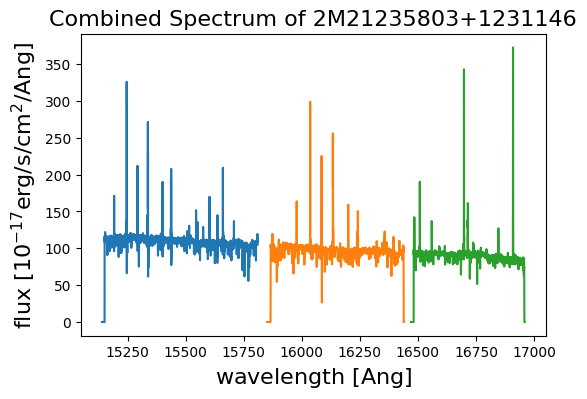

In [10]:
obj = '2M21235803+1231146'
file = fits.open('./specdata/fitsdata/apo25m/M15/apStar-r12-'+obj+'.fits')
data = file[1].data
info = file[0].header
file.close()

wavescale = 10**(np.arange(info['CRVAL1'],info['CRVAL1']+info['NWAVE']*info['CDELT1'],info['CDELT1']))
specdata = data[0]

chip1 = wavescale[np.where((wavescale<15810)&(wavescale>15140))]
chip2 = wavescale[np.where((wavescale>15850)&(wavescale<16440))]
chip3 = wavescale[np.where((wavescale>16470)&(wavescale<16960))]
flux1 = specdata[np.where((wavescale<15810)&(wavescale>15140))]
flux2 = specdata[np.where((wavescale>15850)&(wavescale<16440))]
flux3 = specdata[np.where((wavescale>16470)&(wavescale<16960))]

mask = np.zeros(len(specdata))
mask[np.where(specdata==0)]=1
specdata = np.ma.array(specdata,mask=mask)

fig = plt.figure(figsize = (6,4),dpi=100)
plt.plot(chip1,flux1)
plt.plot(chip2,flux2)
plt.plot(chip3,flux3)
plt.title('Combined Spectrum of '+obj,fontsize=16)
plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=16)
plt.ylabel('flux [$10^{-17}\mathrm{erg/s/cm^2/Ang}$]',fontsize=16)
plt.show()

## What are the units of spectra? Explain what these units mean.
* **$10^{-17}\mathrm{erg/s/cm^2/Ang}$**
* **This units mean how much energy within 1 Ang wavelength flows through area of cm^2 per second.**

# 2

In [92]:
! wget -nv https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits -P ./specdata/fitsdata/

2021-03-16 03:23:38 URL:https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits [3229427520/3229427520] -> "./specdata/fitsdata/allStar-r12-l33.fits" [1]


In [2]:
allstardata = Table.read('./specdata/fitsdata/allStar-r12-l33.fits',format='fits',hdu=1)
allstardata = allstardata[np.where((allstardata['FIELD']=='M15')|(allstardata['FIELD']=='N6791')|(allstardata['FIELD']=='K2_C4_168-21')|(allstardata['FIELD']=='060+00'))]

In [3]:
data1 = allstardata[np.where((allstardata['TEFF']>-9990)&(allstardata['LOGG']>-9990)&\
                      (allstardata['M_H']>-9990)&(allstardata['MG_FE']>-9990)&(allstardata['SI_FE']>-9990))]
data1 = data1[np.where((data1['SNR']>50)|(data1['SNR']==50))]
data1 = data1[np.where((data1['LOGG']<4)|(data1['LOGG']==4))]
data1 = data1[np.where((data1['TEFF']<5700)|(data1['TEFF']==5700))]
data1 = data1[np.where((data1['M_H']>-1))]
allstardata = data1

In [6]:
allstardata.write('specdata/allstar.fits')

## Explain how our cut on log g effectively distinguishes between dwarfs and giants.

* **As we know dwarfs are compact objects with very large density than giants. Great log g comes ith great density. Therefore dwarfs have large logg.**

## Calculate the expected value of log g on the main sequence (when R ~ 1Rsun), just before the helium flash (when R ~ 100Rsun), and during core helium burning (when R ~ 15Rsun).

In [5]:
G = 6.6743e-8 # cm^3 g^-1 s^-2
M_sun = 2e36 # g
R_sun = 6.963e10 # cm
logg1 = np.log10(G*M_sun/R_sun**2)
logg2 = np.log10(G*M_sun/(R_sun*100)**2)
logg3 = np.log10(G*M_sun/(R_sun*15)**2)
print('log g on the main sequence is:',logg1)
print('log g before the helium flash is:',logg2)
print('log g during core helium burning is:',logg3)

log g on the main sequence is: 7.439842928970581
log g before the helium flash is: 3.439842928970581
log g during core helium burning is: 5.087660410859218


## Visualize their distribution in label space using a corner plot.

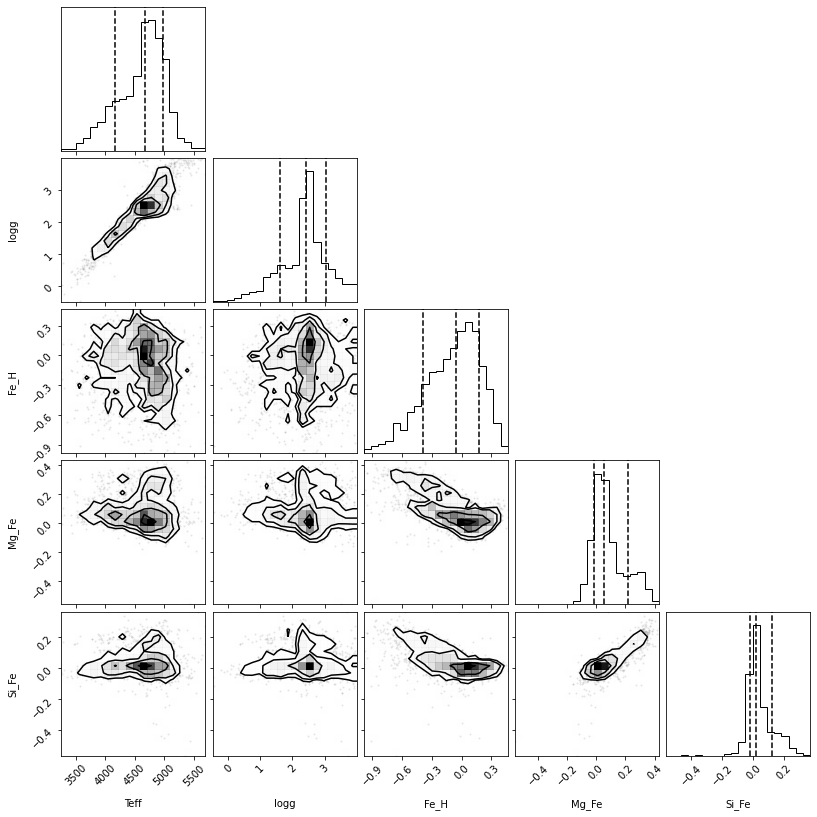

In [4]:
data = allstardata
TEFF,LOGG,M_H,MG_FE,SI_FE = np.array(data['TEFF']),np.array(data['LOGG']),\
                            np.array(data['M_H']),np.array(data['MG_FE']),np.array(data['SI_FE'])
dfdata = {'Teff':TEFF,'logg':LOGG,'Fe_H':M_H,'Mg_Fe':MG_FE,'Si_Fe':SI_FE}
sample = pd.DataFrame(data=dfdata)
_ = corner.corner(sample, quantiles=[.16, .50, .84])
plt.savefig('checkpoint1(b).pdf')

# 3

## Use the apStar bitmasks to identify bad pixels in each spectrum and set the uncertainty in these pixels to a large value

In [16]:
wave = get_wave(cutgaps=True)
specs=[];errs=[]
for obj in allstardata['APOGEE_ID']:
    spec,err = get_flux_err(obj=obj,cutgaps=True)
    specs.append(spec);errs.append(err)

In [62]:
allspectra = pd.DataFrame()
allspectra['wave'] = wave
for i in range(len(allstardata)):
    obj = allstardata['APOGEE_ID'][i]
    allspectra['flux_'+obj] = specs[i]
    allspectra['error_'+obj] = errs[i]

In [27]:
allspectra.to_csv('specdata/allspectra',index=False)

,Unnamed: 0,wavelength,2M03501997+2458304_err,2M03502656+2445432_err,2M03504772+2514178_err,2M03504852+2433483_err,2M03505216+2442325_err,2M03510670+2523599_err,2M03510864+2511250_err,2M03510934+2503195_err,...,2M21350236+1219001_err,2M21350298+1146522_err,2M21350523+1208252_err,2M21350549+1159473_err,2M21350592+1219430_err,2M21351077+1213316_err,2M21351671+1221177_err,2M21352209+1135485_err,2M21352418+1204096_err,2M21354701+1209559_err
0,0,15100.801542,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
1,1,15101.010168,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
2,2,15101.218798,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
3,3,15101.427430,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
4,4,15101.636066,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8570,8570,16998.867941,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
8571,8571,16999.102790,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
8572,8572,16999.337643,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
8573,8573,16999.572500,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


# 4
## Some sanity check on randam spectrum

<ipython-input-18-eb84bd0b33d5>:9: RuntimeWarning: invalid value encountered in true_divide
  f = specdata[i]/norflux
<ipython-input-18-eb84bd0b33d5>:9: RuntimeWarning: invalid value encountered in true_divide
  f = specdata[i]/norflux
<ipython-input-18-eb84bd0b33d5>:9: RuntimeWarning: invalid value encountered in true_divide
  f = specdata[i]/norflux


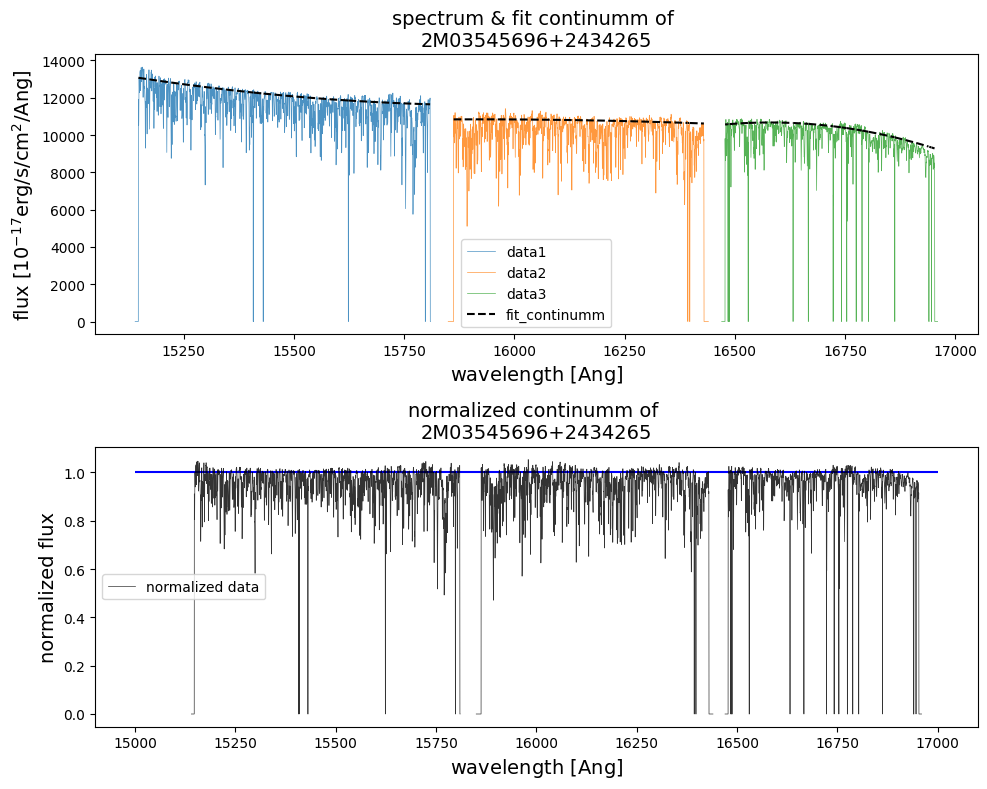

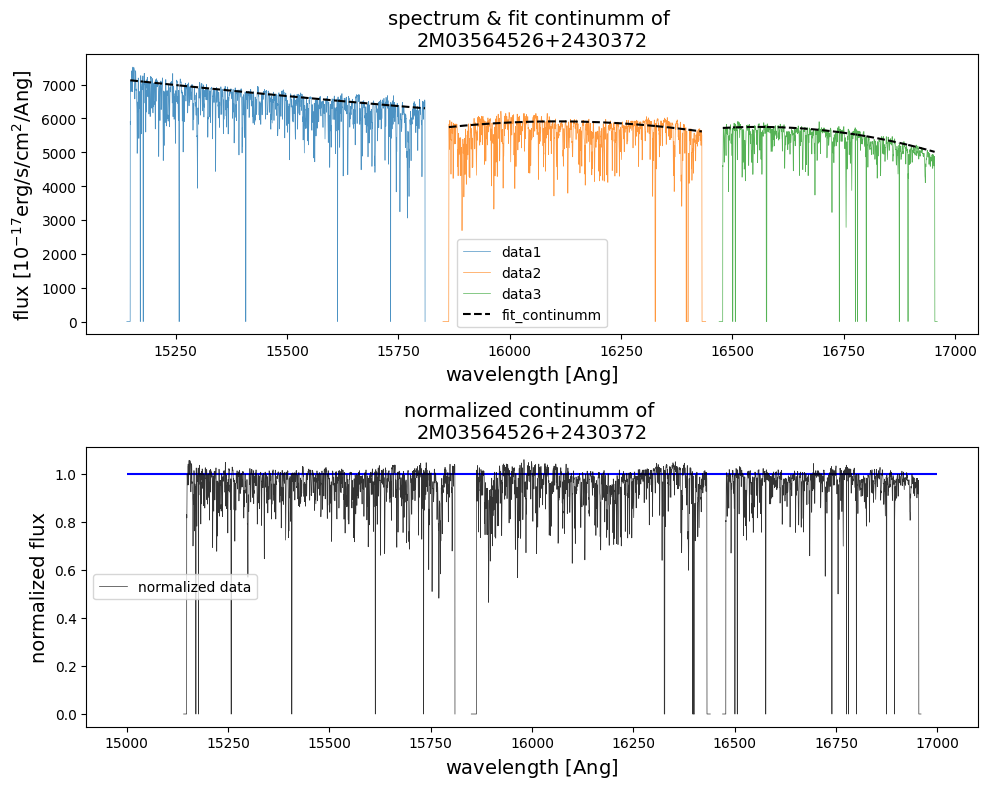

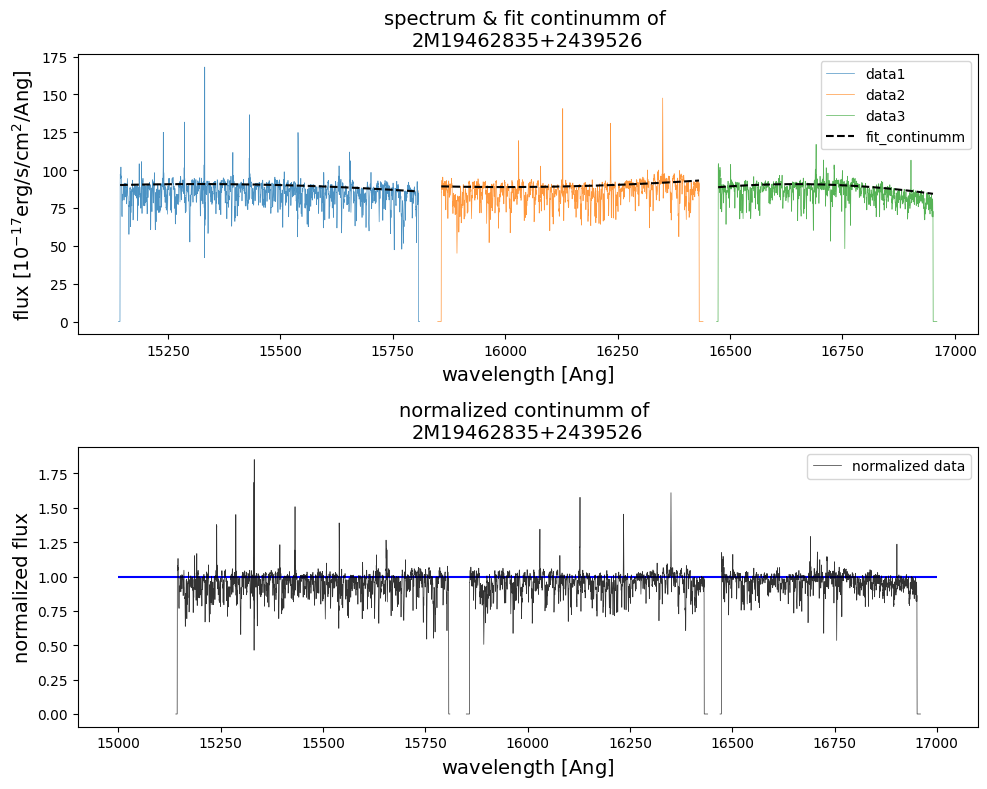

In [18]:
for obj in ALLstardata[np.where((allstardata['TEFF']>4750)&(allstardata['TEFF']<4755))][[1,2,5]]['APOGEE_ID']:

    wavescale = get_wave()
    specdata,err = get_flux_err(obj = obj)
    nor_specdata = [];fs = []
    for i in range(3):
        norflux,_ = get_normalized_spectrum(wavescale[i],specdata[i],err[i],i+1)
        nor_specdata.append(norflux)
        f = specdata[i]/norflux
        fs.append(f)
    f1,f2,f3 = fs

    fig = plt.figure(figsize = (10,8),dpi=100)
    sub1 = plt.subplot(211)
    plt.title('spectrum & fit continumm of \n'+obj,fontsize=14)
    plt.plot(wavescale[0],specdata[0],linewidth=0.5,alpha=0.8,label = 'data1')
    plt.plot(wavescale[1],specdata[1],label = 'data2',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[2],specdata[2],label = 'data3',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[0],f1,'k--',markersize=1,label='fit_continumm')
    plt.plot(wavescale[1],f2,'k--',markersize=1,)
    plt.plot(wavescale[2],f3,'k--',markersize=1,)
    plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
    plt.ylabel('flux [$10^{-17}\mathrm{erg/s/cm^2/Ang}$]',fontsize=14)
    sub1.legend()
    sub2 = plt.subplot(212)
    plt.title('normalized continumm of \n'+obj,fontsize=14)
    plt.hlines(1,xmin=15000,xmax=17000,color='b')
    plt.plot(wavescale[0],nor_specdata[0],'k',linewidth=0.5,alpha=0.8,label='normalized data')
    plt.plot(wavescale[1],nor_specdata[1],'k',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[2],nor_specdata[2],'k',linewidth=0.5,alpha=0.8)
    plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
    plt.ylabel('normalized flux',fontsize=14)
    sub2.legend()
    fig.tight_layout()

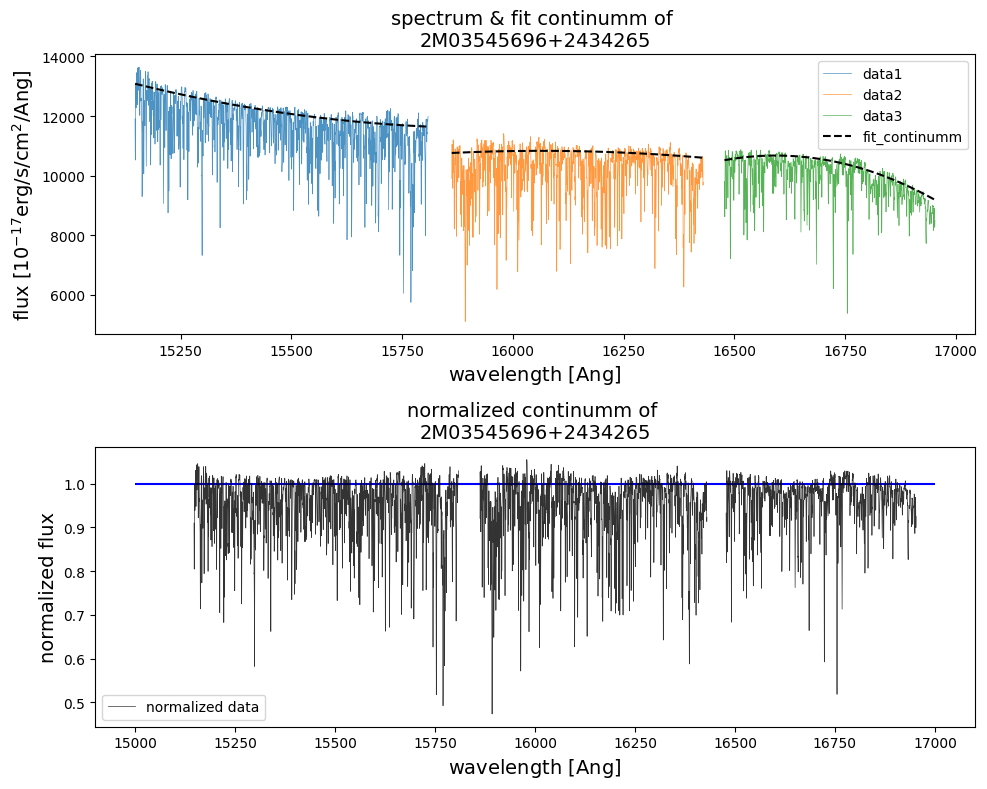

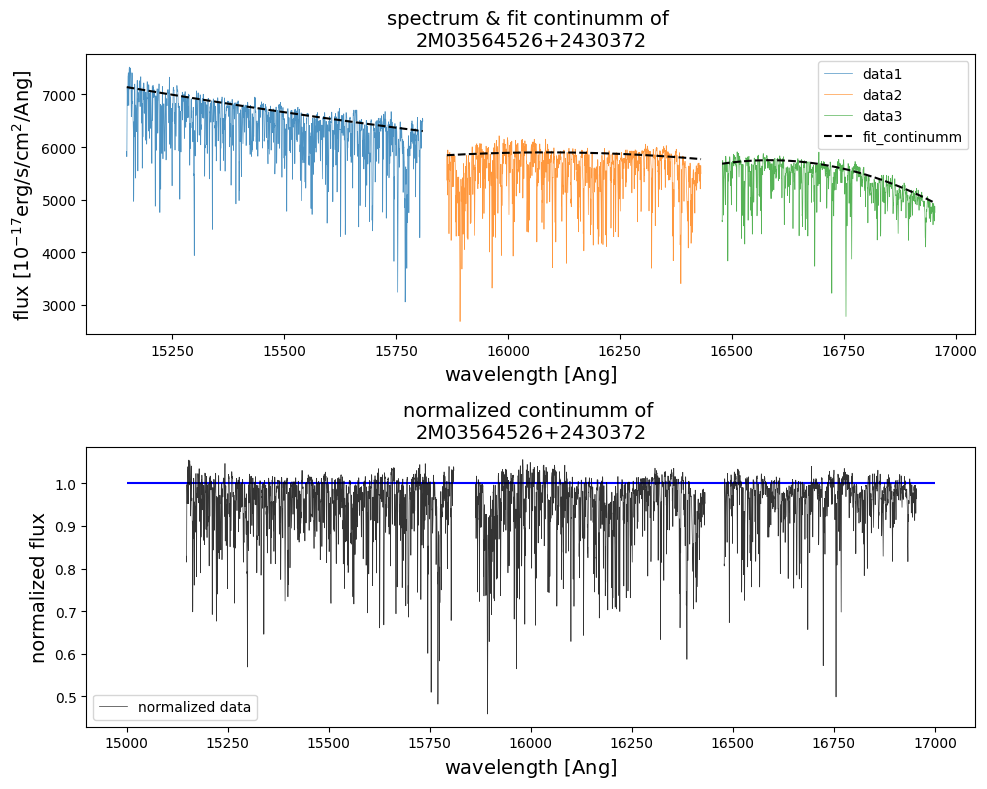

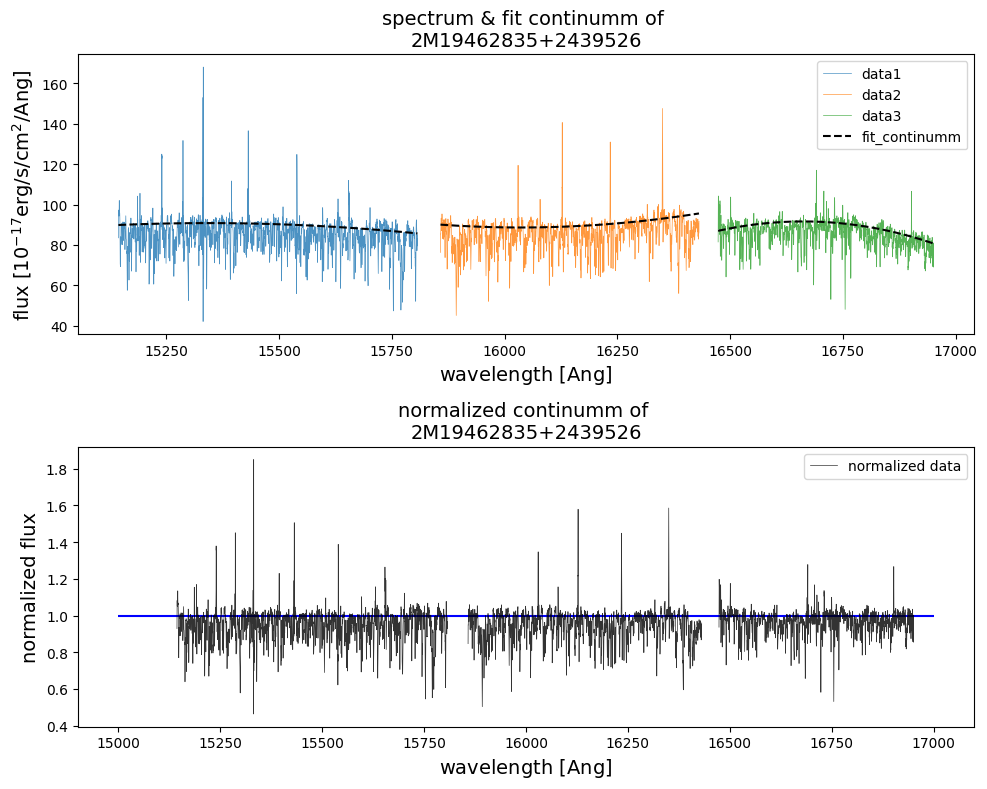

In [60]:
## Just checking if the continumm works
for obj in allstardata[np.where((allstardata['TEFF']>4750)&(allstardata['TEFF']<4755))][[1,2,5]]['APOGEE_ID']:
    specdata,wavescale = get_flux_wave(obj,removezero=True)
    f1,f2,f3=get_fit_to_continuum(obj,fitwave=wavescale)

    nor_specdata = [specdata[0]/f1,specdata[1]/f2,specdata[2]/f3]

    fig = plt.figure(figsize = (10,8),dpi=100)
    sub1 = plt.subplot(211)
    plt.title('spectrum & fit continumm of \n'+obj,fontsize=14)
    plt.plot(wavescale[0],specdata[0],linewidth=0.5,alpha=0.8,label = 'data1')
    plt.plot(wavescale[1],specdata[1],label = 'data2',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[2],specdata[2],label = 'data3',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[0],f1,'k--',markersize=1,label='fit_continumm')
    plt.plot(wavescale[1],f2,'k--',markersize=1,)
    plt.plot(wavescale[2],f3,'k--',markersize=1,)
    plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
    plt.ylabel('flux [$10^{-17}\mathrm{erg/s/cm^2/Ang}$]',fontsize=14)
    sub1.legend()
    sub2 = plt.subplot(212)
    plt.title('normalized continumm of \n'+obj,fontsize=14)
    plt.hlines(1,xmin=15000,xmax=17000,color='b')
    plt.plot(wavescale[0],nor_specdata[0],'k',linewidth=0.5,alpha=0.8,label='normalized data')
    plt.plot(wavescale[1],nor_specdata[1],'k',linewidth=0.5,alpha=0.8)
    plt.plot(wavescale[2],nor_specdata[2],'k',linewidth=0.5,alpha=0.8)
    plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
    plt.ylabel('normalized flux',fontsize=14)
    sub2.legend()
    fig.tight_layout()

## Checkpoint 1

In [20]:
obj = '2M19395986+2341280'
wavescale = get_wave()
specdata,err = get_flux_err(obj = obj)
nor_specdata = [];fs = []
for i in range(3):
    norflux,_ = get_normalized_spectrum(wavescale[i],specdata[i],err[i],i+1)
    nor_specdata.append(norflux)
    f = specdata[i]/norflux
    fs.append(f)
f1,f2,f3 = fs

<ipython-input-20-1b1b74ea889c>:8: RuntimeWarning: invalid value encountered in true_divide
  f = specdata[i]/norflux


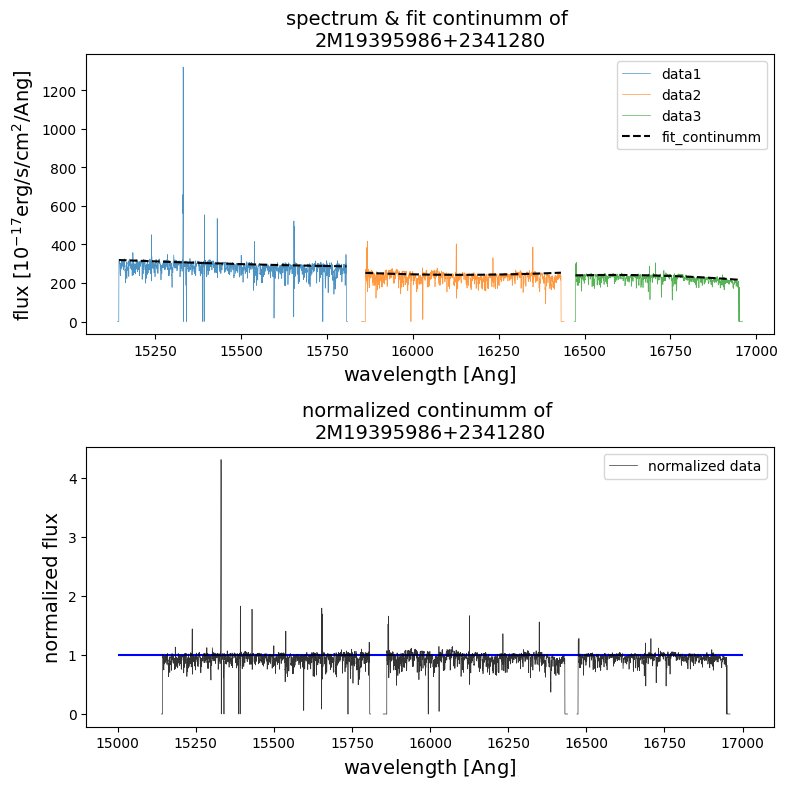

In [21]:
fig = plt.figure(figsize = (8,8),dpi=100)
sub1 = plt.subplot(211)
plt.title('spectrum & fit continumm of \n'+obj,fontsize=14)
plt.plot(wavescale[0],specdata[0],linewidth=0.5,alpha=0.8,label = 'data1')
plt.plot(wavescale[1],specdata[1],label = 'data2',linewidth=0.5,alpha=0.8)
plt.plot(wavescale[2],specdata[2],label = 'data3',linewidth=0.5,alpha=0.8)
plt.plot(wavescale[0],f1,'k--',markersize=1,label='fit_continumm')
plt.plot(wavescale[1],f2,'k--',markersize=1,)
plt.plot(wavescale[2],f3,'k--',markersize=1,)
plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
plt.ylabel('flux [$10^{-17}\mathrm{erg/s/cm^2/Ang}$]',fontsize=14)
sub1.legend()
sub2 = plt.subplot(212)
plt.title('normalized continumm of \n'+obj,fontsize=14)
plt.hlines(1,xmin=15000,xmax=17000,color='b')
plt.plot(wavescale[0],nor_specdata[0],'k',linewidth=0.5,alpha=0.8,label='normalized data')
plt.plot(wavescale[1],nor_specdata[1],'k',linewidth=0.5,alpha=0.8)
plt.plot(wavescale[2],nor_specdata[2],'k',linewidth=0.5,alpha=0.8)
plt.xlabel('wavelength [$\mathrm{Ang}$]',fontsize=14)
plt.ylabel('normalized flux',fontsize=14)
sub2.legend()
fig.tight_layout()
# plt.savefig('checkpoint1(a).pdf')

## Normalize all your spectra and error arrays

In [23]:
specs = [];errs = []
wavescale = get_wave()
for obj in allstardata['APOGEE_ID']:
    specdata,err = get_flux_err(obj = obj)
    nor_specdata = [];nor_errs = []
    for i in range(3):
        norflux,norerr = get_normalized_spectrum(wavescale[i],specdata[i],err[i],i+1)
        nor_specdata.append(norflux);nor_errs.append(norerr)
    nor_specdata = np.hstack((nor_specdata[0],nor_specdata[1],nor_specdata[2]))
    nor_errs = np.hstack((nor_errs[0],nor_errs[1],nor_errs[2]))
    specs.append(nor_specdata);errs.append(nor_errs)

In [24]:
allnormalspectra = pd.DataFrame()
wave = get_wave(cutgaps=True)
allnormalspectra['wave'] = wave
for i in range(len(allstardata)):
    obj = allstardata['APOGEE_ID'][i]
    allnormalspectra['flux_'+obj] = specs[i]
    allnormalspectra['error_'+obj] = errs[i]

In [25]:
allnormalspectra.to_csv('specdata/allnormalspectra',index=False)

In [26]:
for i in range(len(allstardata)):
    if i ==0:
        obj = allstardata['APOGEE_ID'][i]
        allnormalflux = allnormalspectra['flux_'+obj].values
        allnormalerror = allnormalspectra['error_'+obj].values
    elif i ==1:
        obj = allstardata['APOGEE_ID'][i]
        allnormalflux = np.append([allnormalflux],[allnormalspectra['flux_'+obj].values],axis=0)
        allnormalerror = np.append([allnormalerror],[allnormalspectra['error_'+obj].values],axis=0)
    else:
        obj = allstardata['APOGEE_ID'][i]
        allnormalflux = np.append(allnormalflux,[allnormalspectra['flux_'+obj].values],axis=0)
        allnormalerror = np.append(allnormalerror,[allnormalspectra['error_'+obj].values],axis=0)

In [27]:
np.savez('./specdata/allnormalflux',allnormalflux)
np.savez('./specdata/allnormalerror',allnormalerror)

# 5

## divide them into two randomly selected groups of roughly equal size

In [28]:
train_percentage, valid_percentage = (0.50, 0.50)

from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(44)

# make an array with the indices of all the rows in the dataset
ind_arr = np.arange(len(allstardata))
rnd.shuffle(ind_arr)

train_ind, test_ind = train_test_split(ind_arr, train_size=train_percentage, random_state=rnd)
train_ind = np.sort(train_ind);test_ind = np.sort(test_ind)
train_obj = allstardata.iloc[train_ind]['APOGEE_ID']
crossval_obj = allstardata.iloc[test_ind]['APOGEE_ID']

# 6(a)


## What is X?how many free parameters are in $\theta_\lambda$ (where n = 5 in your case)?


* **According to Ness,**
$$\begin{array}
ff_{n\lambda}=\theta^T_{\lambda}\cdot l_n + noise
\end{array}$$

**where $l_n$ is the label vector, $\theta_{\lambda}$ is the free parameters vector, noise is $[s^2_\lambda + \sigma ^2_{n\lambda}]\xi_{n\lambda}$. So when noise is fixed, the spectral model for the pixel can be described by a linear equation**


* **X is**
    $$ {\bf X}=\left(
    \begin{array}{cccc}
    1 & Teff_{1} & logg_{1} & [Fe/H]_{1} & [Mg/Fe]_{1} & [Si/Fe]_{1} &\
    Teff_{1}^{2} & Teff_{1}\cdot logg_{1} & Teff_{1}\cdot [Fe/H]_{1} & Teff_{1}\cdot[Mg/Fe]_{1} & Teff_{1}\cdot[Si/Fe]_{1} &\
    logg_{1}^{2} & logg_{1}\cdot[Fe/H]_{1} & logg_{1}\cdot[Mg/Fe]_{1} & logg_{1}\cdot[Si/Fe]_{1} &\
    [Fe/H]_{1}^{2} & [Fe/H]_{1}\cdot[Mg/Fe]_{1} & [Fe/H]_{1}\cdot[Si/Fe]_{1} &\
    [Mg/Fe]_{1}^{2} & [Mg/Fe]_{1}\cdot[Si/Fe]_{1} & [Si/Fe]_{1}^{2}\\
    1 & Teff_{2} & logg_{2} & [Fe/H]_{2} & [Mg/Fe]_{2} & [Si/Fe]_{2} &\
    Teff_{2}^{2} & Teff_{2}\cdot logg_{2} & Teff_{2}\cdot [Fe/H]_{2} & Teff_{2}\cdot[Mg/Fe]_{2} & Teff_{2}\cdot[Si/Fe]_{2} &\
    logg_{2}^{2} & logg_{2}\cdot[Fe/H]_{2} & logg_{2}\cdot[Mg/Fe]_{2} & logg_{2}\cdot[Si/Fe]_{2} &\
    [Fe/H]_{2}^{2} & [Fe/H]_{2}\cdot[Mg/Fe]_{2} & [Fe/H]_{2}\cdot[Si/Fe]_{2} &\
    [Mg/Fe]_{2}^{2} & [Mg/Fe]_{2}\cdot[Si/Fe]_{2} & [Si/Fe]_{2}^{2}\\
     & \cdots\cdots
    \end{array}\right)$$


* **There are 21 parameters in $\theta_\lambda$.**

## 6(b)

In [30]:
def get_coeffs(X,y,err):
    '''
    Solve the model linear equation to get the 21 paramters as an array.
    '''
    A = np.dot(X.T,np.diag(1/err**2))
    wX = np.dot(A,X)
    wy = np.dot(A,y)
    
    coeff, resid, _, _ = np.linalg.lstsq(wX, wy,rcond=None)

    return coeff

# log-likelihood function.
def lnlike(coeff,X,y,sig,s):
    noise = s**2+sig**2
    fit = np.dot(X,coeff)
    diff = y-fit
    return np.nansum(-0.5 * ((diff)**2/noise + np.log(noise)))

In [31]:
# Choose \lambda = 15350.693484909549 

ind = [1000]
X = make_labels_matrix(objs = train_obj)

# When testing through the wavelength, I found s^2 is mostly at 1e-5 order of magnitude.
# Therefore the prior of s^2 is as below.
prior = np.linspace(0,0.1,51)

for waveind in ind:
    y,err = get_normalized_spectra_at_wave(train_ind,waveind)
    coeff = get_coeffs(X=X,y=y,err=err)
    hoods = []
    for s in prior:
        s = np.ones(len(err))*s
        prob = lnlike(coeff,X,y,err,s)
        hoods.append(prob)

    s = prior[np.argmax(hoods)]
    
    print('coeff:',coeff)
    print('s^2:',s**2)

coeff: [-0.27036011  0.59573047 -0.11320127  0.11466514  0.25749094  0.06999933
 -0.06847015  0.02105329 -0.00870328 -0.03141258 -0.01723526  0.00274218
 -0.01899342 -0.04494166  0.01846937  0.03638214  0.05473768 -0.16865627
  0.19521287 -0.38392462 -0.14127846]
s^2: 6.4e-05


## 6(c)

In [32]:
wave = get_wave(cutgaps=True)

X = make_labels_matrix(objs = train_obj)
prior = np.linspace(0,0.1,51)

for waveind in range(len(wave)):
    y,err = get_normalized_spectra_at_wave(train_ind,waveind)
    coeff = get_coeffs(X=X,y=y,err=err)

    hoods = []
    for s in prior:
        s = np.ones(len(err))*s
        prob = lnlike(coeff,X,y,err,s)
        hoods.append(prob)
    s = prior[np.argmax(hoods)]
    para = np.append(coeff,s)
    if waveind == 0:
        paras = para
    elif waveind ==1:
        paras = np.append([paras],[para],axis=0)
    else:
        paras = np.append(paras,[para],axis=0)

In [33]:
np.savez('./specdata/modelparas',paras)

## 6(d) Write a function that predict the normalized spectrum.

In [34]:
def predict_normalized_spectrum(labels,waveind):
    '''labels = [teff,logg,FeH,MgFe,SiFe]'''
    
    teff,logg,FeH,MgFe,SiFe = labels
    X = make_labels_array(teff,logg,FeH,MgFe,SiFe)
    theta = paras[waveind][:,:-1]
    y_pre = np.dot(theta,X)
    return y_pre

## 7

In [9]:
obj = '2M03533659+2512012'
wave = get_wave(cutgaps=True)
ind = np.where((wave>16000)&(wave<16100))
testwave = wave[ind]
testflux,err = get_normalized_spectra_fromdf(obj)
testflux = testflux.values[ind]
err = err.values[ind]

labels = allstardata.loc[(allstardata['APOGEE_ID'].isin([obj])),\
                                    ['TEFF','LOGG','M_H','MG_FE','SI_FE']].values.T.reshape(5,)

y_predict = predict_normalized_spectrum(labels,ind)

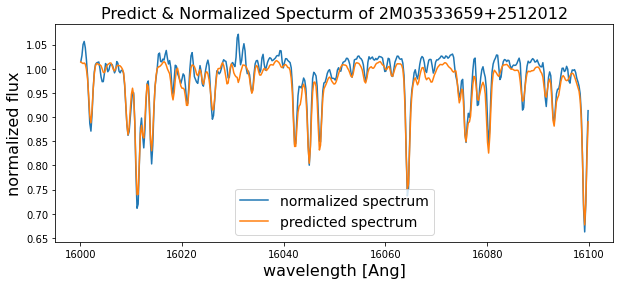

In [10]:
mask = [testflux/err<20]
testwave = np.ma.array(testwave,mask=mask)
testflux = np.ma.array(testflux,mask=mask)
y_predict = np.ma.array(y_predict,mask=mask)

figure = plt.figure(figsize=(10,4))
plt.plot(testwave,testflux,label='normalized spectrum')
plt.plot(testwave,y_predict,label = 'predicted spectrum')
plt.xlabel('wavelength [Ang]',fontsize=16)
plt.ylabel('normalized flux',fontsize=16)
plt.legend(fontsize=14)
plt.title('Predict & Normalized Specturm of '+obj,fontsize=16)
plt.show()

## 8

In [96]:
obj = '2M03533659+2512012'

plotflux,_ = get_normalized_flux_error(obj)
plotwave = get_wave(cutgaps=True)

teff = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['TEFF'][0]
logg = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['LOGG'][0]
FeH = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['M_H'][0]
MgFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['MG_FE'][0]
SiFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['SI_FE'][0]
dif_t = 1000;dif_l = 1;dif_f = 0.8;dif_m = 0.8;dif_s = 0.8
labelst = [teff-dif_t,logg,FeH,MgFe,SiFe]
labelsl = [teff,logg-dif_l,FeH,MgFe,SiFe]
labelsf = [teff,logg,FeH-dif_f,MgFe,SiFe]
labelsm = [teff,logg,FeH,MgFe-dif_m,SiFe]
labelss = [teff,logg,FeH,MgFe,SiFe-dif_s]

y_predict = predict_normalized_spectrum(labelst,plotwave); difffluxt = plotflux-y_predict
y_predict = predict_normalized_spectrum(labelsl,plotwave); difffluxl = plotflux-y_predict
y_predict = predict_normalized_spectrum(labelsf,plotwave); difffluxf = plotflux-y_predict
y_predict = predict_normalized_spectrum(labelsm,plotwave); difffluxm = plotflux-y_predict
y_predict = predict_normalized_spectrum(labelss,plotwave); difffluxs = plotflux-y_predict

dfdt = difffluxt/dif_t; dfdl = difffluxl/dif_l
dfdf = difffluxf/dif_f; dfdm = difffluxm/dif_m; dfds = difffluxs/dif_s

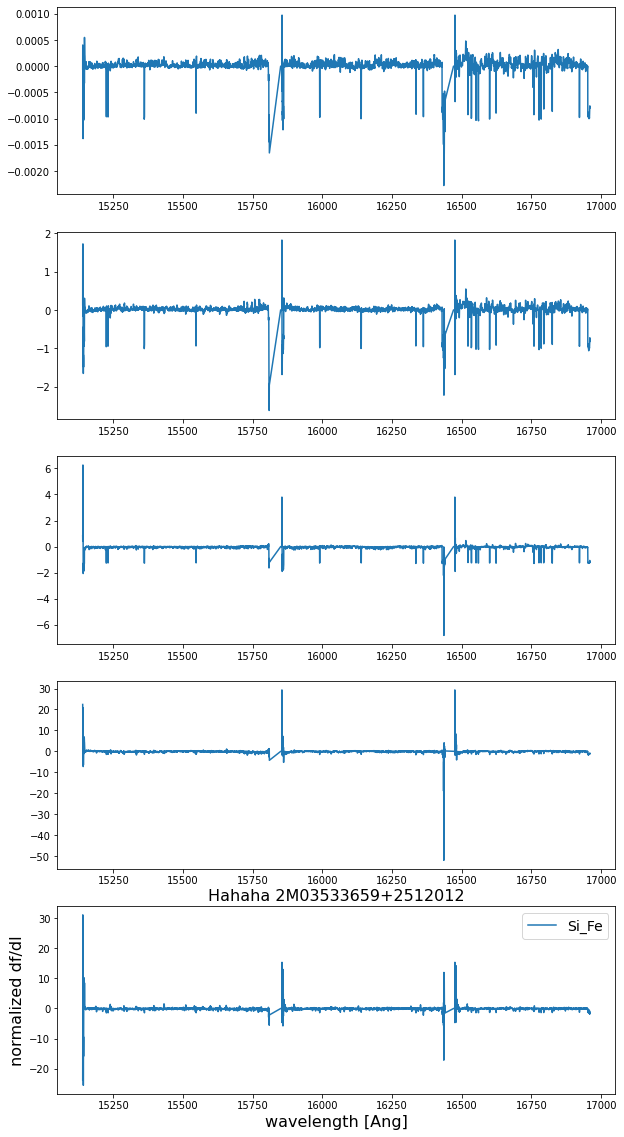

In [97]:
figure = plt.figure(figsize=(10,20))
plt.subplot(511)
plt.plot(plotwave,dfdt,label='Teff')
plt.subplot(512)
plt.plot(plotwave,dfdl,label='Logg')
plt.subplot(513)
plt.plot(plotwave,dfdf,label='Fe_H')
plt.subplot(514)
plt.plot(plotwave,dfdm,label='Mg_Fe')
plt.subplot(515)
plt.plot(plotwave,dfds,label='Si_Fe')
plt.xlabel('wavelength [Ang]',fontsize=16)
plt.ylabel('normalized df/dl',fontsize=16)
plt.legend(fontsize=14)
plt.title('Hahaha '+obj,fontsize=16)
plt.show()

## 9

In [58]:
from scipy.optimize import curve_fit

In [88]:
def linear_function(theta,*labels):
    return np.sum(labels*theta,axis=1)

def get_labels(obj):
    teff = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['TEFF'][0]
    logg = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['LOGG'][0]
    FeH = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['M_H'][0]
    MgFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['MG_FE'][0]
    SiFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['SI_FE'][0]
    labels = [teff,logg,FeH,MgFe,SiFe]
    return labels

def get_fit_labels(objs):
    theta = paras.loc[:,['1','Teff','Logg','Fe_H','Mg_Fe','Si_Fe',\
                                  'Teff2','Teff_Logg','Teff_Fe','Teff_Mg','Teff_Si',\
                                  'Logg2','Log_Fe','Log_Mg','Log_Si',\
                                  'Fe_H2','Fe_Mg','Fe_Si','Mg_Fe2','Mg_Si','Si_Fe2']]
    s2 = np.array(paras.loc[:,['s2']])[:,0]

    theta = theta.values

    labels = []
    for obj in objs:
        spectra,err = get_normalized_flux_error(obj)
        popt, pcov = curve_fit(linear_function,theta,spectra,[1.0] * 21,sigma=np.sqrt(err**2+s2**2),method='trf')
        popt[1] = popt[1]*1e3
        labels.append(popt[1:6])
    return labels

In [138]:
fitlabels = get_fit_labels(crossval_obj)
fitlabels = np.array(labels).T

In [87]:
def plot_compare_residual(x,y,quantity,units,n=5):
    '''
    Example:
    plot_compare_residual(x=[pfs_rrab,'calculated period'],y=[job1['pf'],'gaia period'],quantity='period',units='[d]')
    '''
    ploty,ylabel = y
    plotx,xlabel = x
    diffs = []
    for source in range(len(plotx)):  
        diff = plotx[source]-ploty[source]
        diffs.append(diff)


    axis1min = min(np.min(plotx),np.min(ploty))-0.1*(max(np.max(plotx),np.max(ploty))-min(np.min(plotx),np.min(ploty)))
    axis1max = max(np.max(plotx),np.max(ploty))+0.1*(max(np.max(plotx),np.max(ploty))-min(np.min(plotx),np.min(ploty)))
    axis2min = -max(abs(np.max(diffs)),abs(np.min(diffs)))-2*abs(max(abs(np.max(diffs)),abs(np.min(diffs))))/n
    axis2max = max(abs(np.max(diffs)),abs(np.min(diffs)))+2*abs(max(abs(np.max(diffs)),abs(np.min(diffs))))/n
    
    
    fig = plt.figure(figsize=(8,10),dpi=70)
    ax1 = plt.axes([0.15, 0.35, 0.8, 0.5])
    plt.plot(np.linspace(int(axis1min)-1,int(axis1max)+1),np.linspace(int(axis1min)-1,int(axis1max)+1),'k--',linewidth=1)
    plt.plot(plotx,ploty,'.',color='darkred',alpha=0.8,markersize=5,label=xlabel)
    plt.xlim(axis1min,axis1max)
    plt.ylim(axis1min,axis1max)
    plt.ylabel(ylabel+' '+units+' ',fontsize=20,labelpad=20)
    plt.xticks(visible=False)
    plt.yticks(fontsize=18)
    plt.title("Compare "+quantity,fontsize=22,pad=13)
    ax2 = plt.axes([0.15, 0.14, 0.8, 0.2])
    plt.axhline(0,linestyle='--',color='k',linewidth=1)
    plt.plot(plotx,diffs,'.',markersize=6,alpha=0.8)
    plt.xlabel(xlabel+' '+units+' ',fontsize=20,labelpad=10)
    plt.xlim(axis1min,axis1max)
    plt.ylim(axis2min,axis2max)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('residual',fontsize=20)
    plt.show()

In [151]:
alllabels = []
for obj in crossval_obj:
    data = get_labels(obj)
    alllabels.append(data)
    
alllabels = np.array(alllabels).T

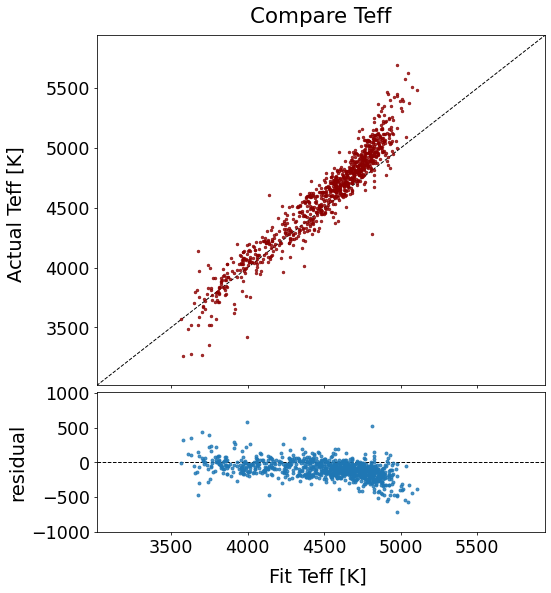

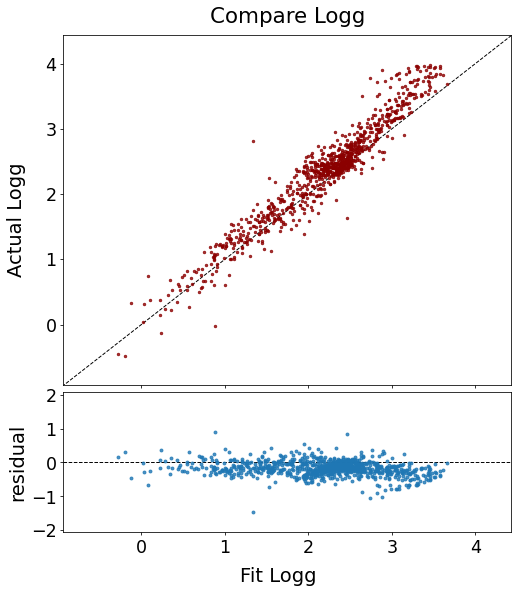

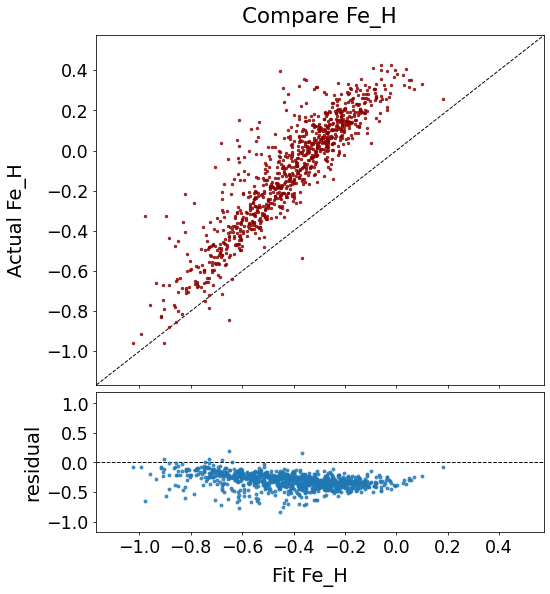

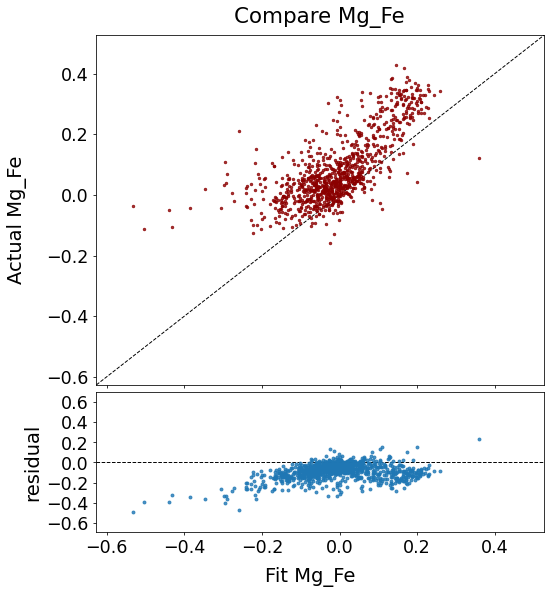

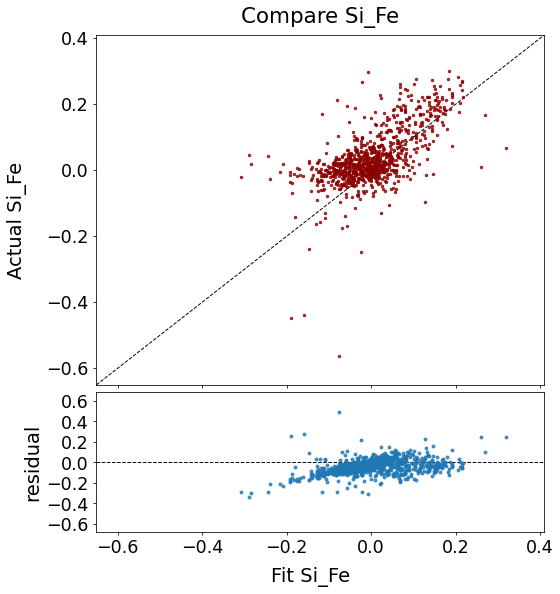

In [160]:
for i in range(5):
    xlabel = ['Fit Teff','Fit Logg','Fit Fe_H','Fit Mg_Fe','Fit Si_Fe']
    ylabel = ['Actual Teff','Actual Logg','Actual Fe_H','Actual Mg_Fe','Actual Si_Fe']
    quantity = ['Teff','Logg','Fe_H','Mg_Fe','Si_Fe']
    units = ['[K]',' ',' ',' ', ' ']
    plot_compare_residual(x=[fitlabels[i],xlabel[i]],y=[alllabels[i],ylabel[i]],quantity=quantity[i],units=units[i])

# 11

## plot a Kiel diagram

In [86]:
def get_mistiso_info(file):
    '''
    This is a function that return the head information, ages and metallicity of the given file.
        
    '''
    
    iso_file = file
    f = open(iso_file)
    data = f.readlines()
    f.close()
    data = data
    try:
        data.remove('\n')
    except:
        pass
    para_ind = [];null = []
    for i in range(len(data)):
        if data[i] == "\n":
            null.append(i)
    for index in null:
        data.remove('\n')
    for i in range(len(data)):
        if data[i][0] == "#":
            para_ind.append(i)
        
    if len(para_ind)<14:
        ages = str(round(float(data[para_ind[-1]+1].split()[1]),2))
        paras = [0]*2
        for i in range(len(para_ind)):
            para = data[para_ind[i]]

            if i ==0:
                paras[0] = [para]
            elif i<10:
                paras[0].append(para)
            elif i ==10:
                paras[1] = ["Age:"+ages,"Info Rows:"+str(para_ind[i])+"-"+str(para_ind[i+2]),
                            "Data Rows:"+str(para_ind[i+2]+1)+"-"+str(len(data)-1),para]
            elif i ==12:
                paras[1].append (para.split())
            
    else:
        ages = []
        paras = [0]*(int((len(para_ind)-10)/3)+1)
        for i in range(len(para_ind)):
            para = data[para_ind[i]]

            if i ==0:
                paras[0] = [para]
            elif i<10:
                paras[0].append(para)
            elif (i-10)%3 == 0:
                age = str(round(float(data[para_ind[i+2]+1].split()[1]),2))
                ages.append(age)
                try:
                    paras[(i-10)//3+1] = ["Age:"+str(age),"Info Rows:"+str(para_ind[i])+"-"+str(para_ind[i+2]),
                                        "Data Rows:"+str(para_ind[i+2]+1)+"-"+str(para_ind[i+3]-1),para]
                except:
                    paras[(i-10)//3+1] = ["Age:"+str(age),"Info Rows:"+str(para_ind[i])+"-"+str(para_ind[i+2]),
                                        "Data Rows:"+str(para_ind[i+2]+1)+"-"+str(len(data)-1),para]
            elif (i-10)%3 == 2:
                paras[(i-10)//3+1].append (para.split())
        

    metallicity = paras[0][5].split()[3]
    return paras,ages,metallicity

# This is a function that return the dataframe of the given MIST iso file.
def MIST_iso_to_dataframe(file):
    '''
    This is a function that return the dataframe of the given MIST iso file.
        
    '''
    iso_file = file
    f = open(iso_file)
    data = f.readlines()
    f.close()
    
    paras,ages,metallicity = get_mistiso_info(iso_file)
    isot = Table.read(iso_file, format='ascii')
    isodatadf = pd.DataFrame(isot.to_pandas())
    isodatadf.columns = paras[1][4][1:]
    
    return isodatadf

In [219]:
df = get_MIST_data('specdata/MIST_iso_0.iso.cmd')
MIST_teff = 10**df.log_Teff.values
MIST_logg = df.log_g.values

df2 = get_MIST_data('specdata/MIST_iso_-1.iso.cmd')
MIST_teff2 = 10**df2.log_Teff.values
MIST_logg2 = df2.log_g.values

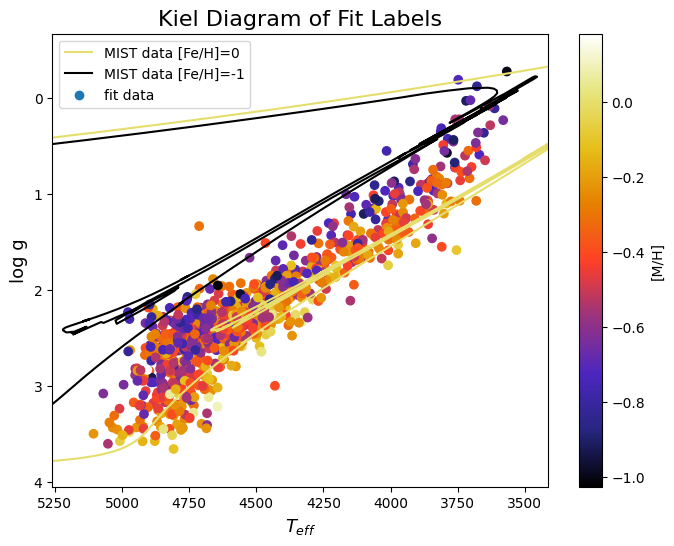

In [223]:
fig = plt.figure(figsize=(8,6),dpi=100)
plt.scatter(fitlabels[0],fitlabels[1],c=fitlabels[2],cmap='CMRmap',label='fit data')
plt.plot(MIST_teff,MIST_logg,c='#E6DE6C',label='MIST data [Fe/H]=0')
plt.plot(MIST_teff2,MIST_logg2,c='k',label='MIST data [Fe/H]=-1')
plt.colorbar(label='[M/H]')
plt.xlim((np.max(fitlabels[0])+0.1*(np.max(fitlabels[0])-np.min(fitlabels[0])),\
          np.min(fitlabels[0])-0.1*(np.max(fitlabels[0])-np.min(fitlabels[0]))))
plt.ylim((np.max(fitlabels[1])+0.1*(np.max(fitlabels[1])-np.min(fitlabels[1])),\
          np.min(fitlabels[1])-0.1*(np.max(fitlabels[1])-np.min(fitlabels[1]))))
plt.xlabel('$T_{eff}$',fontsize=13)
plt.ylabel('log g',fontsize=13)
plt.title('Kiel Diagram of Fit Labels',fontsize=16)
plt.legend()
plt.show()

# 12

**Defined prior:**
* $T_{eff} \sim {\rm Uniform}(0,10000)$
* $log~g \sim {\rm Uniform}(-10,10)$
* $[M/H] \sim {\rm Uniform}(-10,10)$
* $[Mg/Fe] \sim {\rm Uniform}(-10,10)$
* $[Si/Fe] \sim {\rm Uniform}(-10,10)$
* $y_n \sim {\rm Normal}( X \theta , \sigma)$

In [42]:
import pymc3 as pm
import arviz as az
from arviz import plot_trace as traceplot

In [9]:
file = 'specdata/mystery_spec_wiped.fits'
wavescale = get_wave()
specdata,error = get_flux_err(file)
normalized = []
normalized_err = []
for i in range(3):
    normal,normal_err = get_normalized_spectrum(wavescale[i],specdata[i],error[i],i+1)
    normalized.append(normal)
    normalized_err.append(normal_err)

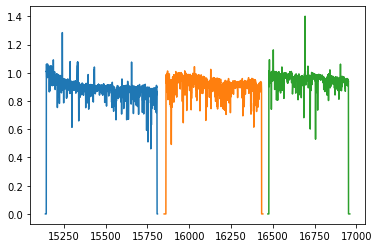

In [10]:
plt.plot(wavescale[0],normalized[0])
plt.plot(wavescale[1],normalized[1])
plt.plot(wavescale[2],normalized[2])

In [31]:
y = np.hstack((normalized[0],normalized[1],normalized[2]))
yerr = np.hstack((normalized_err[0],normalized_err[1],normalized_err[2]))
theta = paras.loc[:,['1','Teff','Logg','Fe_H','Mg_Fe','Si_Fe',\
                                  'Teff2','Teff_Logg','Teff_Fe','Teff_Mg','Teff_Si',\
                                  'Logg2','Log_Fe','Log_Mg','Log_Si',\
                                  'Fe_H2','Fe_Mg','Fe_Si','Mg_Fe2','Mg_Si','Si_Fe2']].values
s2 = paras.s2.values

In [41]:
with pm.Model() as model:
    
    # define priors
    teff = pm.Uniform("Teff", lower=0, upper=10)
    logg = pm.Uniform("Log g", lower=-1, upper=5)
    FeH = pm.Uniform("M_H", lower=-3, upper=1)
    MgFe = pm.Uniform("Mg_Fe", lower=-3, upper=1)
    SiFe = pm.Uniform("Si_Fe", lower=-3, upper=1)
    
    # define the log-likelihood function
    pm.Normal("obs", mu = 1*theta[:,0]+teff*theta[:,1]+logg*theta[:,2]+\
                          FeH*theta[:,3]+MgFe*theta[:,4]+SiFe*theta[:,5]+\
                          teff**2*theta[:,6]+teff*logg*theta[:,7]+teff*FeH*theta[:,8]+\
                          teff*MgFe*theta[:,9]+teff*SiFe*theta[:,10]+logg**2*theta[:,11]+\
                          logg*FeH*theta[:,12]+logg*MgFe*theta[:,13]+logg*SiFe*theta[:,14]+
                          FeH**2*theta[:,15]+FeH*MgFe*theta[:,16]+FeH*SiFe*theta[:,17]+\
                          MgFe**2*theta[:,18]+MgFe*SiFe*theta[:,19]+SiFe**2*theta[:,20],\
              sd=pm.math.sqrt(s2+yerr**2), observed=y)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace0 = pm.sample(draws=1000, tune=1000, chains=2, cores=4)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = traceplot(trace0, var_names=["Teff","Log g","M_H", "Mg_Fe","Si_Fe"])

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Si_Fe, Mg_Fe, M_H, Log g, Teff]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2268 seconds.
The acceptance probability does not match the target. It is 0.9873086792158572, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


NameError: name 'traceplot' is not defined

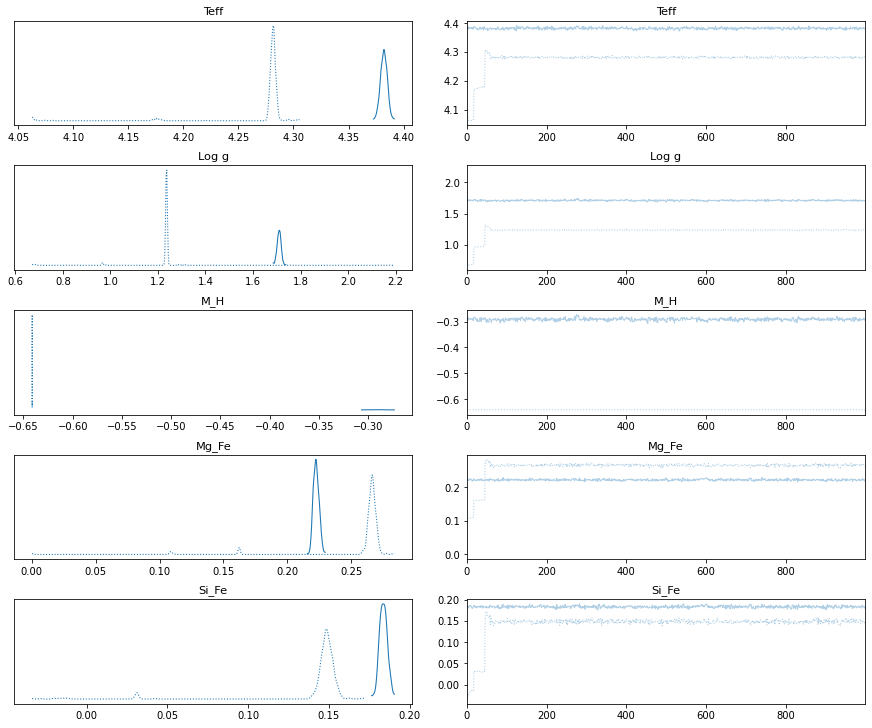

In [44]:
_ = traceplot(trace0, var_names=["Teff","Log g","M_H", "Mg_Fe","Si_Fe"])

In [46]:
az.summary(trace0, var_names=["Teff","Log g","M_H", "Mg_Fe","Si_Fe"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Teff,4.329,0.058,4.277,4.387,0.038,0.032,3.0,32.0,1.84
Log g,1.466,0.252,1.230,1.723,0.173,0.146,3.0,38.0,1.84
M_H,-0.466,0.175,-0.641,-0.286,0.123,0.104,3.0,16.0,1.84
Mg_Fe,0.241,0.028,0.218,0.270,0.015,0.013,4.0,81.0,1.84
Si_Fe,0.163,0.029,0.143,0.189,0.016,0.015,3.0,32.0,1.83


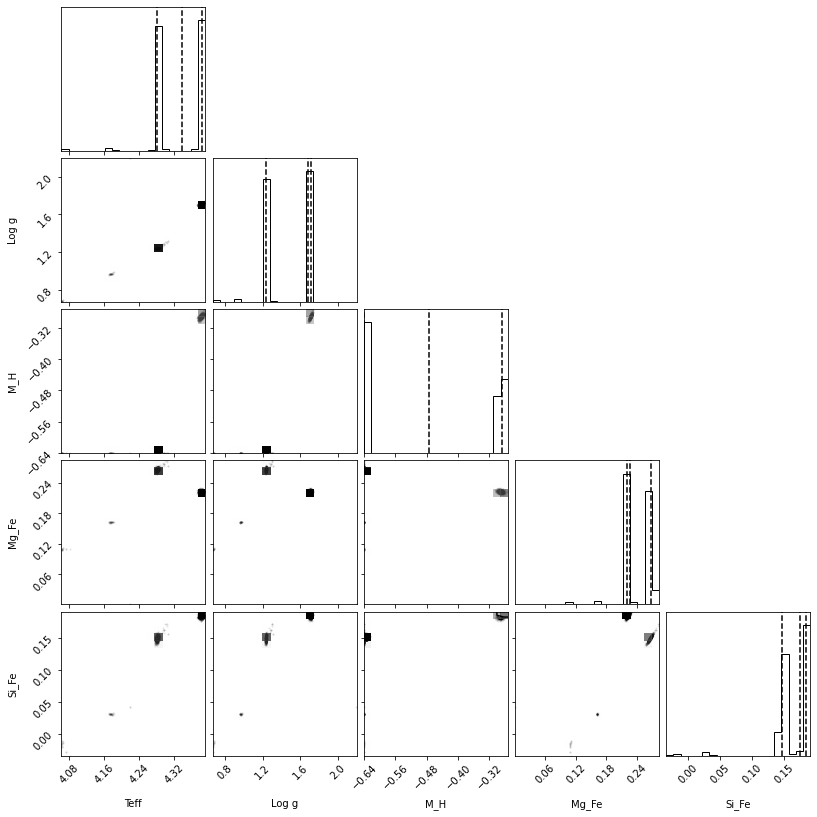

In [47]:
samples0 = pm.trace_to_dataframe(trace0, varnames=["Teff","Log g","M_H", "Mg_Fe","Si_Fe"])
_ = corner.corner(samples0, quantiles=[.16, .50, .84])

In [48]:
from IPython.display import display, Math

units =[r'{\, \rm K}', r'{\, \rm  }', r'{\, \rm  }', r'{\, \rm  }', r'{\, \rm  }']
labels = ["Teff","Log g","M_H", "Mg_Fe","Si_Fe"]

for i, j in enumerate(samples0.keys()):
    if j == 'logsig':
        summary = np.percentile(np.exp(samples0[j]), [16, 50, 84])
    else:
        summary = np.percentile(samples0[j], [16, 50, 84])
    diff = np.diff(summary)
    mathtext = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    mathtext = mathtext.format(summary[1], diff[0], diff[1], labels[i])
    display(Math(mathtext + "  "+ units[i]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# 13

In [7]:
from matplotlib.animation import FuncAnimation

In [36]:
obj = '2M03533659+2512012'
df = pd.read_csv('specdata/normalized_data/'+obj+'_data2')
flux = df['2M03533659+2512012_specdata']
wave = get_wave()

plotwave = wave[1][np.where((wave[1]>16000)&(wave[1]<16200))]

teff = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['TEFF'][0]
logg = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['LOGG'][0]
MgFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['MG_FE'][0]
SiFe = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['SI_FE'][0]

y_predicts = []
for FeH in np.arange(-1,0.5,0.01):
    labels = [teff,logg,FeH,MgFe,SiFe]
    y_predict = predict_normalized_spectrum(labels,plotwave)
    y_predicts.append(y_predict)

<IPython.core.display.Javascript object>


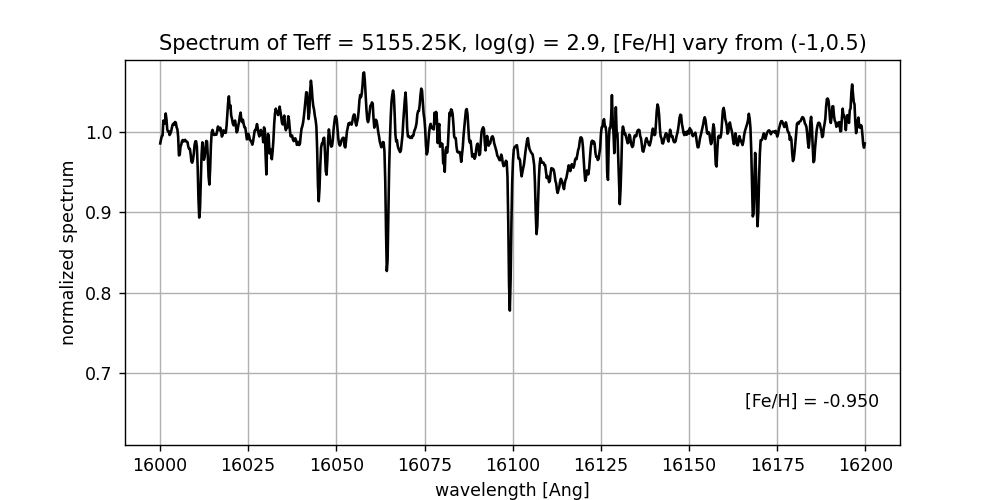

In [47]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot(plotwave, y_predicts[0], '-k',animated=False)
ax.grid()

plt.ylim(0.61, 1.09)
plt.xlabel('wavelength [Ang]')
plt.ylabel('normalized spectrum')
plt.title('Spectrum of Teff = '+str(np.round(teff,2))+'K, log(g) = '+str(np.round(logg,2))+', [Fe/H] vary from (-1,0.5)')

time_template = '[Fe/H] = %.3f'
time_text = ax.text(0.8, 0.1, '', transform=ax.transAxes)

def update(i):
    newy = y_predicts[i]
    line.set_data(plotwave, newy)
    time_text.set_text(time_template %(-1+0.01*i))
    return line,time_text

ani = FuncAnimation(fig, update, frames=range(len(y_predicts)), 
                                  interval=100,repeat=True)
ani.save('imgs/13.gif', writer='pillow',fps=30)
plt.show()

<IPython.core.display.Javascript object>


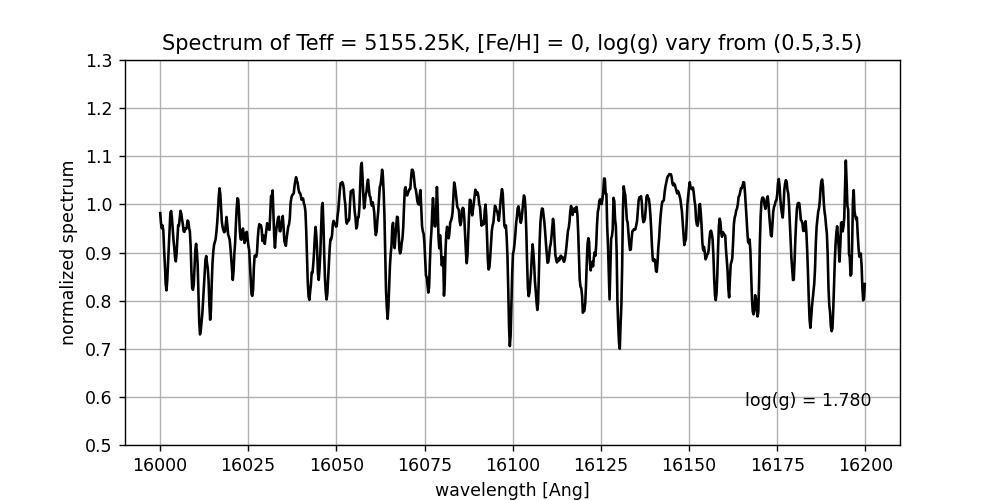

In [54]:
FeH = 0
y_predicts = []
for logg in np.arange(0.5,3.5,0.02)[::-1]:
    labels = [teff,logg,FeH,MgFe,SiFe]
    y_predict = predict_normalized_spectrum(labels,plotwave)
    y_predicts.append(y_predict)
    
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot(plotwave, y_predicts[0], '-k',animated=False)
ax.grid()

plt.ylim(0.5, 1.3)
plt.xlabel('wavelength [Ang]')
plt.ylabel('normalized spectrum')
plt.title('Spectrum of Teff = '+str(np.round(teff,2))+'K, [Fe/H] = 0, log(g) vary from (0.5,3.5)')

time_template = 'log(g) = %.3f'
time_text = ax.text(0.8, 0.1, '', transform=ax.transAxes)

def update(i):
    newy = y_predicts[i]
    line.set_data(plotwave, newy)
    time_text.set_text(time_template %(3.5-0.02*i))
    return line,time_text

ani = FuncAnimation(fig, update, frames=range(len(y_predicts)), 
                                  interval=100,repeat=True)
ani.save('imgs/14.1.gif', writer='pillow',fps=30)
plt.show()

In [64]:
logg = allstardata[np.where(allstardata['APOGEE_ID']==obj)]['LOGG'][0]
y_predicts = []
for teff in np.arange(2000,5000,10):
    labels = [teff,logg,FeH,MgFe,SiFe]
    y_predict = predict_normalized_spectrum(labels,plotwave)
    y_predicts.append(y_predict)
    
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot(plotwave, y_predicts[0], '-k',animated=False)
ax.grid()

plt.ylim(-0.8, 2.4)
plt.xlabel('wavelength [Ang]')
plt.ylabel('normalized spectrum')
plt.title('Spectrum of logg = '+str(np.round(logg,2))+'K, [Fe/H] = 0, Teff vary from (2000,5000)')

time_template = 'teff = %.3f'
time_text = ax.text(0.8, 0.1, '', transform=ax.transAxes)

def update(i):
    newy = y_predicts[i]
    line.set_data(plotwave, newy)
    time_text.set_text(time_template %(2000+10*i))
    return line,time_text

ani = FuncAnimation(fig, update, frames=range(len(y_predicts)), 
                                  interval=100,repeat=True)
ani.save('imgs/14.2.gif', writer='pillow',fps=30)
plt.show()

<IPython.core.display.Javascript object>

# 15

# 16

In [7]:
from sklearn.preprocessing import PowerTransformer
import datetime, os

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import tensorflow as tf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Print keras version
print(tensorflow.keras.__version__)

from tensorflow import keras
print(f"backend={keras.backend.backend()}")

2.4.0
backend=tensorflow


#### Prepare training and test data. 
* **Because three models for three wave chips are going to be built, there are three datasets.**

In [53]:
%matplotlib inline

train_Y  = [];test_Y  = []
train_X1 = [];test_X1 = []
train_X2 = [];test_X2 = []
train_X3 = [];test_X3 = []
for obj in train_obj:
    y = get_labels(obj)
    x,_ = get_normalized_flux_error(obj=obj,alldata=False)
    train_X1.append(x[0]);train_X2.append(x[1]);train_X3.append(x[2])
    train_Y.append(y)
for obj in crossval_obj:
    y = get_labels(obj)
    x,_ = get_normalized_flux_error(obj=obj,alldata=False)
    test_X1.append(x[0]);test_X2.append(x[1]);test_X3.append(x[2])
    test_Y.append(y)

train_Y = np.array(train_Y);test_Y = np.array(test_Y)
train_X1 = np.array(train_X1);test_Y = np.array(test_X1)

# trans1 = PowerTransformer();trans2 = PowerTransformer();trans3 = PowerTransformer()

# # fit on training data
# trans1.fit(train_X1)
# train_X1 = trans1.transform(train_X1)
# trans2.fit(train_X2)
# train_X2 = trans2.transform(train_X2)  
# trans3.fit(train_X3)
# train_X3 = trans3.transform(train_X3)  

# # apply same transformation to test data
# test_X1 = trans1.transform(test_X1)
# test_X2 = trans2.transform(test_X2)
# test_X3 = trans3.transform(test_X3)

num_input_features1 = train_X1.shape[1]
# num_input_features2 = train_X2.shape[1]
# num_input_features3 = train_X3.shape[1]

#### Define model function.

In [49]:
model1 = Sequential()
model1.add(Dense(32, input_shape=(num_input_features1,), 
                  activation="relu", kernel_initializer='random_uniform'))
model1.add(Dense(32,  activation="relu", kernel_initializer='random_uniform'))
model1.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
model1.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))
model1.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])

model2 = Sequential()
model2.add(Dense(32, input_shape=(num_input_features1,), 
                  activation="relu", kernel_initializer='random_uniform'))
model2.add(Dense(32,  activation="relu", kernel_initializer='random_uniform'))
model2.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
model2.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))
model2.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])

model3 = Sequential()
model3.add(Dense(32, input_shape=(num_input_features1,), 
                  activation="relu", kernel_initializer='random_uniform'))
model3.add(Dense(32,  activation="relu", kernel_initializer='random_uniform'))
model3.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
model3.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))
model3.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])

In [50]:
import os

from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, \
                                                ReduceLROnPlateau, ModelCheckpoint, TensorBoard

try:
    os.mkdir('nn_results')
except:
    pass

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

# define path to save model
model_path = f'nn_results/datalab_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

# Tensorboard is a project which can ingest learning logs for interactive display...
# more on that later.
tb = TensorBoard(log_dir='nn_results', histogram_freq=0,
                 write_graph=True, 
                 write_grads=False, 
                 write_images=False, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None, embeddings_data=None)

reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.75,
                              patience=3, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = EarlyStopping(monitor='val_mse', min_delta=0.001, patience=10, \
                          verbose=1, mode='auto')

model_check = ModelCheckpoint(model_path,
        monitor='val_mse', 
        save_best_only=True, 
        mode='min',
        verbose=1)

Training ... nn_results/datalab_nn_2021-04-09T09:20.h5


In [51]:
batch_size=32
num_epochs = 200
history1 = model1.fit(x=train_X1, y=train_Y,batch_size=batch_size,
               epochs=num_epochs,
               validation_data=(test_X1, test_Y),
               verbose=1, shuffle=True,
               callbacks=[csv_logger, earlystop, model_check, tb])

Epoch 1/200
29/29 [==============================] - 1s 19ms/step - loss: 4316825.9333 - mae: 926.5528 - mse: 4316825.9333 - val_loss: 737479557266800640.0000 - val_mae: 28193426.0000 - val_mse: 737479557266800640.0000

Epoch 00001: val_mse improved from inf to 737479557266800640.00000, saving model to nn_results/datalab_nn_2021-04-09T09:20.h5
Epoch 2/200
29/29 [==============================] - 0s 6ms/step - loss: 4259303.9000 - mae: 932.7240 - mse: 4259303.9000 - val_loss: 195595043767956013056.0000 - val_mae: 459140192.0000 - val_mse: 195595043767956013056.0000

Epoch 00002: val_mse did not improve from 737479557266800640.00000
Epoch 3/200
29/29 [==============================] - 0s 6ms/step - loss: 3992233.2750 - mae: 1062.4434 - mse: 3992233.2750 - val_loss: 7706449344165522178048.0000 - val_mae: 2881970944.0000 - val_mse: 7706449344165522178048.0000

Epoch 00003: val_mse did not improve from 737479557266800640.00000
Epoch 4/200
29/29 [==============================] - 0s 6ms/step

In [26]:
!ls nn_results

datalab_nn_2021-04-09T08:11.h5	training_2021-04-09T08:11.log
datalab_nn_2021-04-09T08:14.h5	training_2021-04-09T08:14.log
datalab_nn_2021-04-09T08:33.h5	training_2021-04-09T08:33.log
datalab_nn_2021-04-09T08:42.h5	training_2021-04-09T08:42.log
train				validation


In [27]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model1 = load_model("nn_results/datalab_nn_2021-04-09T08:42.h5")
pred_y1 = model1.predict(test_X1)

MSE 1.1965417189859278e+17


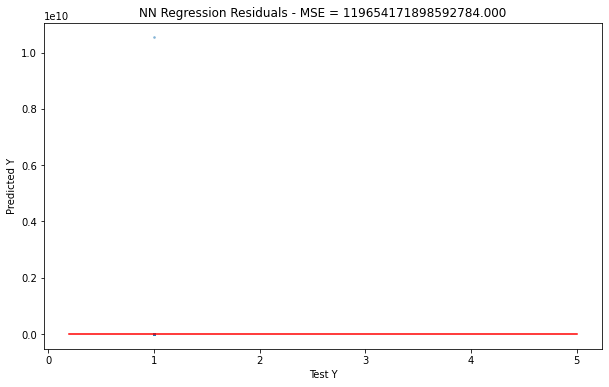

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_Y[:,0], pred_y1[:,0]); print("MSE",mse)

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(test_Y[:,0],pred_y1[:,0],alpha=0.4,s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2,5],[0.2,5],c="r")